In [ ]:
import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import json
import time
import re # Import regex for answer parsing

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    next_node_decision: str

# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1.  **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2.  **Socratic Method:** Break down complex problems into smaller, manageable questions.
3.  **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4.  **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5.  **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this when you want to generate a multiple-choice question for **well-known or predefined topics** (like "variables", "functions", "classes"). This tool has pre-built questions.
    * `llm_mcq_generator`: Use this when the user asks for an MCQ on a topic that is **not explicitly covered by the `mcq_agent`'s predefined list**, or if you believe a more custom or nuanced question is needed based on the current discussion. This tool will ask the LLM to create a new MCQ.
    * `mcq_answer_processor`: Use this tool when the user submits an answer to an active MCQ. Provide the user's answer and the correct answer to this tool. This tool will handle updating the struggle count and resetting the MCQ state.
6.  **Maintain Context:** Keep track of the current topic and sub_topic.
7.  **Be Patient and Encouraging:** Foster a positive learning environment.
8.  **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question} # Note: This is now the formatted string
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str) -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback.
    This tool is used by the `process_mcq_answer` node.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return "Correct!"
    else:
        return "Incorrect."


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    # Invoke the Socratic agent runnable with the current state.
    # Exclude 'messages' and 'next_node_decision' as they are handled separately by LangGraph/prompt.
    response = socratic_agent_runnable.invoke({
        "messages": state["messages"],
        **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
    })
    print("[DEBUG] LLM Response:", response)
    
    thought = ""
    display_content = response.content # Initialize with the full content from LLM

    # Extract the internal "Thought:" from the LLM's response if present.
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        thought_and_content = parts[1].strip()
        
        # The thought is typically the first line after "Thought:"
        thought_lines = thought_and_content.split('\n', 1)
        thought = thought_lines[0].strip()
        
        # The display content is the rest, if any
        if len(thought_lines) > 1:
            display_content = thought_lines[1].strip()
        else:
            display_content = "" # If only thought was present, hide it from user display

    # Create a new AIMessage to add to the state, preserving tool calls.
    new_ai_message = AIMessage(
        content=display_content,
        tool_calls=response.tool_calls
    )

    # Return the updated messages and the extracted thought.
    return {"messages": [new_ai_message], "agent_thought": thought}

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    """
    Executes a tool call requested by the Socratic LLM.
    Updates the state with the tool's output and relevant MCQ information if applicable.
    """
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1] # Get the last message, which should contain tool calls.
    
    messages_to_add = [] # List to accumulate new messages (e.g., ToolMessage)
    state_updates = {}   # Dictionary to accumulate state changes

    # Check if the last message is an AIMessage and contains tool calls.
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name) # Get the actual function for the tool.
            
            tool_output_content = ""
            if tool_function:
                response = tool_function.invoke(tool_args) # Invoke the tool.
                tool_output_content = str(response) # Convert tool response to string.

                # Special handling for MCQ generation tools (`mcq_agent`, `llm_mcq_generator`)
                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        # If mcq_agent couldn't find a predefined MCQ, add a ToolMessage
                        # and continue, allowing the LLM to potentially call llm_mcq_generator next.
                        messages_to_add.append(
                            ToolMessage(content="No predefined MCQ found for this topic.", tool_call_id=tool_call["id"])
                        )
                        continue # Skip to next tool call or finish this loop.
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        # Check if the MCQ generation tool returned an error.
                        if "error" in mcq_data:
                            messages_to_add.append(
                                ToolMessage(content=f"Error generating MCQ: {mcq_data['error']}", tool_call_id=tool_call["id"])
                            )
                            continue # Skip if there was an error.

                        # Update state with MCQ details if generation was successful.
                        state_updates["mcq_active"] = True
                        state_updates["mcq_question"] = mcq_data.get("question", "")
                        state_updates["mcq_options"] = mcq_data.get("options", [])
                        state_updates["mcq_correct_answer"] = mcq_data.get("correct_answer", "")
                        # If a topic wasn't set yet in the state, set it from the tool arguments.
                        if not state.get("topic") and tool_args.get("topic"):
                            state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        # Handle cases where the tool's output is not valid JSON.
                        messages_to_add.append(
                            ToolMessage(content="Error: MCQ agent returned invalid JSON.", tool_call_id=tool_call["id"])
                        )
                        continue # Skip to next tool call or finish this loop.

                # Special handling for the `mcq_answer_processor` tool.
                elif tool_name == "mcq_answer_processor":
                    if tool_output_content == "Correct!":
                        state_updates["user_struggle_count"] = 0 # Reset struggle count on correct answer.
                    else:
                        # Increment struggle count on incorrect answer.
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    
                    # Reset MCQ state after processing an answer.
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                
                # For all other tools, just append their output as a ToolMessage.
                messages_to_add.append(
                    ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                )

            else:
                # If a tool function is not found, add an error message.
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    # Return the new messages and any state updates.
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1] # Get the latest message in the conversation.
    
    next_decision = ""
    # Check if an MCQ is active and the user's last message looks like an MCQ answer.
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        # Use regex to robustly match typical MCQ answer formats (A, B, C, D, A., B), etc.
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but no valid answer, routing to call_llm (Socratic Agent).")
            next_decision = "call_llm" # If MCQ active but answer is not valid, let LLM handle it
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    # Return a dictionary with the decision. LangGraph nodes must return a dict.
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    """
    Processes the user's MCQ answer by calling the mcq_answer_processor tool directly.
    This node is invoked by the `router` when an MCQ answer is detected.
    It updates the state based on the correctness of the answer and provides feedback.
    """
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    # Find the most recent HumanMessage in the history.
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []} # If no human message, nothing to process.

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")

    # Directly call the `mcq_answer_processor` tool function.
    tool_output_content = mcq_answer_processor.invoke({"user_answer": user_answer, "correct_answer": correct_answer})
    
    state_updates = {}
    messages_to_add = []

    # Update struggle count based on the tool's output.
    if tool_output_content == "Correct!":
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    # Reset all MCQ-related state variables as the MCQ has been answered.
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""

    # Add a ToolMessage to the history to record the tool's execution.
    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call") # Using a dummy ID for direct call.
    )
    # Add an AIMessage to provide immediate feedback to the user.
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    
    # Return the new messages and any state updates.
    return {"messages": messages_to_add, **state_updates}


# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    """
    Determines if the Socratic LLM (after its `call_llm` node) needs to call a tool
    or if its turn is complete (i.e., it has generated a direct response).
    """
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    # If the last message from the LLM contains tool calls, transition to `call_tool`.
    if isinstance(state["messages"][-1], AIMessage) and state["messages"][-1].tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    # Otherwise, the LLM's turn is complete, and the graph can end for this iteration.
    print("[DEBUG] should_continue_socratic: Socratic agent's turn ends (no tool calls).")
    return END

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", END: END} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile()

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "", # Topic will be set by the tool if not provided by user
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "agent_thought": "",
    "next_node_decision": "" # Initialize this for the router
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='a8e565cf-c1ed-4977-8989-760b78f97cfe')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--0fb0e40d-3e73-41a5-8652-4141a84de7e0-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '7e61c2d9-05b3-4859-973a-d90c18da6fbb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1188, 'outpu

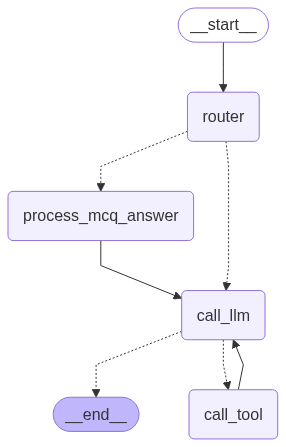


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='5cca2d54-896d-4a78-abb0-8089f3360139')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'mcq_agent', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--44ef6222-2b3c-4e4a-bd41-507b75ea8720-0' tool_calls=[{'name': 'mcq_agent', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '04aca61f-8333-447c-91f4-0a32de1a12fd', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1267, 'output_tokens': 22, '

In [8]:
# --- Test ---
# This section provides example invocations to test the graph's behavior.
# It includes tests for LLM-generated MCQs, correct/incorrect MCQ answers,
# and regular conversation turns.

try:
    from IPython.display import Image, display
    # Attempt to draw and display the graph for visualization.
    display(Image(socratic_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}. This is often due to missing graphviz or pydot.")

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "", # Topic will be set by the tool if not provided by user
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "agent_thought": "",
    "next_node_decision": "" # Initialize this for the router
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)

# Test answering the MCQ (Correct Answer)
# print("\n--- Testing answering the MCQ (Correct Answer) ---")
# # Use the state from the previous step which now contains the active MCQ.
# mcq_answer_state_correct = result_llm_mcq 
# mcq_answer_state_correct["messages"].append(HumanMessage(content="B")) # User answers 'B'
# mcq_answer_state_correct["next_node_decision"] = "" # Reset for router to make a fresh decision
# result_mcq_answer_correct = socratic_graph.invoke(mcq_answer_state_correct)
# pprint.pprint(result_mcq_answer_correct)

# # Test answering the MCQ (Incorrect Answer)
# print("\n--- Testing answering the MCQ (Incorrect Answer) ---")
# # Reset state for a new MCQ test to ensure independence.
# llm_mcq_state_2 = {
#     "messages": [HumanMessage(content="Can you give me another MCQ, this time on Python generators?")],
#     "difficulty_level": "advanced",
#     "user_struggle_count": 0,
#     "topic": "",
#     "sub_topic": "",
#     "mcq_active": False,
#     "mcq_question": "",
#     "mcq_options": [],
#     "mcq_correct_answer": "",
#     "agent_thought": "",
#     "next_node_decision": ""
# }
# result_llm_mcq_2 = socratic_graph.invoke(llm_mcq_state_2)
# pprint.pprint(result_llm_mcq_2)

# mcq_answer_state_incorrect = result_llm_mcq_2 # Use the state from the previous step.
# mcq_answer_state_incorrect["messages"].append(HumanMessage(content="A")) # User answers 'A'
# mcq_answer_state_incorrect["next_node_decision"] = "" # Reset for router
# result_mcq_answer_incorrect = socratic_graph.invoke(mcq_answer_state_incorrect)
# pprint.pprint(result_mcq_answer_incorrect)

# print("\n--- Testing a regular conversation turn after MCQ ---")
# # Continue conversation after an MCQ has been answered.
# regular_turn_state = result_mcq_answer_incorrect # Use the state from the previous step.
# regular_turn_state["messages"].append(HumanMessage(content="Can you explain more about generators?"))
# regular_turn_state["next_node_decision"] = "" # Reset for router
# result_regular_turn = socratic_graph.invoke(regular_turn_state)
# pprint.pprint(result_regular_turn)

In [ ]:
import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import json
import re # Import regex for answer parsing
import time

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        mcq_explaination: The explaination for the mcq answer
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    mcq_explanation: str 
    agent_thought: str
    next_node_decision: str

# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", max_retries=3, temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", max_retries=3, temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1. **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2. **Socratic Method:** Break down complex problems into smaller, manageable questions.
3. **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4. **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5. **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this only for well-known topics like "variables", "functions", "classes", "conditional statements", "comparisons", or "maximum of three numbers".
    * `llm_mcq_generator`: Use this for all other topics (e.g., "Python decorators", "context managers") or when a custom MCQ is needed.
    * `mcq_answer_processor`: Use this when the user submits an answer to an active MCQ.
6. **Maintain Context:** Keep track of the current topic and sub_topic.
7. **Be Patient and Encouraging:** Foster a positive learning environment.
8. **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.
9. **MCQ Answer Format:** When presenting an MCQ, instruct the user to respond with a single letter (A, B, C, or D) to indicate their answer choice.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question}
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str, explanation: str = "") -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback with explanation.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return f"Correct!\n\nExplanation: {explanation}"
    else:
        return f"Incorrect.\n\nExplanation: {explanation}"


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            response = socratic_agent_runnable.invoke({
                "messages": state["messages"],
                **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
            })
            print("[DEBUG] LLM Response:", response)
            
            content = response.content
            if isinstance(content, list):
                content = "\n".join(str(item) for item in content)
            elif not isinstance(content, str):
                print("[ERROR] Unexpected content type:", type(content))
                content = ""

            thought = ""
            display_content = ""
            if content and content.startswith("Thought:"):
                parts = content.split("Thought:", 1)
                thought_and_content = parts[1].strip()
                thought_lines = thought_and_content.split('\n', 1)
                thought = thought_lines[0].strip()
                display_content = thought_lines[1].strip() if len(thought_lines) > 1 else ""
            else:
                display_content = content

            new_ai_message = AIMessage(
                content=display_content,
                tool_calls=response.tool_calls
            )

            return {"messages": [new_ai_message], "agent_thought": thought}
        except Exception as e:
            print(f"[ERROR] LLM invocation failed (attempt {attempt + 1}/{max_attempts}):", str(e))
            if attempt == max_attempts - 1:
                return {
                    "messages": [AIMessage(content="An issue occurred, but you can still answer the MCQ with A, B, C, or D.")],
                    "agent_thought": f"Error during LLM invocation: {str(e)}"
                }
            time.sleep(2.0)

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1]
    messages_to_add = []
    state_updates = {}

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name)
            
            if tool_function:
                response = tool_function.invoke(tool_args)
                tool_output_content = str(response)

                existing_tool_message = any(
                    isinstance(msg, ToolMessage) and msg.tool_call_id == tool_call["id"]
                    for msg in state["messages"]
                )
                
                if not existing_tool_message:
                    messages_to_add.append(
                        ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                    )

                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        messages_to_add.append(
                            AIMessage(content="No predefined MCQ found for this topic. Generating a new one...")
                        )
                        continue
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        if "error" in mcq_data:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                        else:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        messages_to_add.append(
                            AIMessage(content="Error: MCQ agent returned invalid JSON. Please try again.")
                        )
                        continue
                elif tool_name == "mcq_answer_processor":
                    if "Correct!" in tool_output_content:
                        state_updates["user_struggle_count"] = 0
                    else:
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                    state_updates["mcq_explanation"] = ""
            else:
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1]
    
    next_decision = ""
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but invalid answer, prompting for valid input.")
            return {
                "next_node_decision": "call_llm",
                "messages": [AIMessage(content="Please respond with a single letter (A, B, C, or D) to select your answer.")]
            }
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []}

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    explanation = state.get("mcq_explanation", "No explanation available.")
    
    tool_output_content = mcq_answer_processor.invoke({
        "user_answer": user_answer,
        "correct_answer": correct_answer,
        "explanation": explanation
    })
    
    state_updates = {}
    messages_to_add = []

    if "Correct!" in tool_output_content:
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""
    state_updates["mcq_explanation"] = ""

    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call")
    )
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    return {"messages": messages_to_add, **state_updates}

# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    last_message = state["messages"][-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    elif state.get("mcq_active", False) and isinstance(last_message, AIMessage) and "Please select an option (A, B, C, or D)" in last_message.content:
        print("[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.")
        return "END"
    elif isinstance(last_message, AIMessage) and "An issue occurred" in last_message.content:
        print("[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.")
        return "END"
    else:
        print("[DEBUG] should_continue_socratic: Routing to call_llm for further interaction.")
        return "call_llm"

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", "END": END, "call_llm": "call_llm"} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile()

# Example test for the new LLM-generated MCQ
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}
result_llm_mcq = socratic_graph.invoke(llm_mcq_state)
import pprint
pprint.pprint(result_llm_mcq)




--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--40cc2315-b1a2-4e50-94ba-966a1f5077c4-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '77210a20-0ce9-418a-ba60-0905ed96a940', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1139, 'outpu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 2/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 3/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 500 An internal error has '
                  'occurred. Please retry or report in '
                  'https://developers.generativeai.google/guide/troubleshooting',
 'difficulty_level': 'intermediate',
 'mcq_active': False,
 'mcq_correct_answer': '',
 'mcq_explanation': '',
 'mcq_options': [],
 'mcq_question': '',
 'messages': [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58'),
              AIMessage(content='', additional_kwargs={}, response_metadata={}, id='66237953-a8b9-4a21-9113-757a4297bc43', tool_calls=[{'name': 'llm_mcq

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 2/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 3/3): 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 500 An internal error has '
                  'occurred. Please retry or report in '
                  'https://developers.generativeai.google/guide/troubleshooting',
 'difficulty_level': 'intermediate',
 'mcq_active': False,
 'mcq_correct_answer': '',
 'mcq_explanation': '',
 'mcq_options': [],
 'mcq_question': '',
 'messages': [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='cad543fa-8293-4894-a77c-eb17d8629d58'),
              AIMessage(content='', additional_kwargs={}, response_metadata={}, id='66237953-a8b9-4a21-9113-757a4297bc43', tool_calls=[{'name': 'llm_mcq

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed (attempt 1/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 5
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
].


[ERROR] LLM invocation failed (attempt 2/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing

[ERROR] LLM invocation failed (attempt 3/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
]
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 429 You exceeded your current '
                  'quota, please check your plan and billing details. Fo

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].


[ERROR] LLM invocation failed (attempt 2/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 51
}
]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
].


[ERROR] LLM invocation failed (attempt 3/3): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
]
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.
{'agent_thought': 'Error during LLM invocation: 429 You exceeded your current '
                  'quota, please check your plan and billing details. Fo

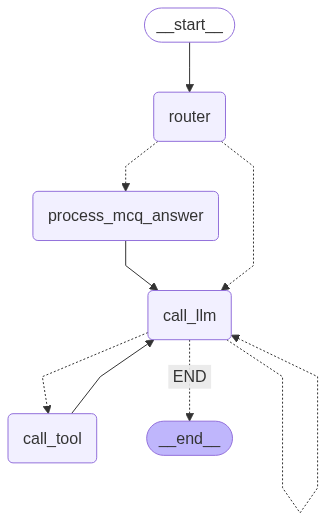

In [ ]:
# Adding Memory to the LangGraph

import os
from typing import List, Dict, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
import json
import re # Import regex for answer parsing
import time

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic tutoring agent.
    
    Attributes:
        messages: A list of BaseMessage objects representing the conversation history.
                  Annotated with add_messages to automatically append new messages.
        difficulty_level: The current difficulty level of the tutoring session (e.g., "beginner", "intermediate").
        user_struggle_count: An integer tracking how many times the user has struggled or answered incorrectly.
        topic: The main Python topic currently being discussed.
        sub_topic: A more specific sub-topic within the main topic.
        mcq_active: A boolean indicating if a Multiple Choice Question is currently active.
        mcq_question: The full text of the active MCQ, including options.
        mcq_options: A list of strings, each representing an option for the active MCQ.
        mcq_correct_answer: The correct answer (e.g., "A", "B", "C", "D") for the active MCQ.
        mcq_explaination: The explaination for the mcq answer
        agent_thought: The internal thought process of the Socratic LLM before generating a response.
        next_node_decision: A string indicating the next node the router should transition to.
                            Used by the supervisor/router to control graph flow.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    mcq_explanation: str 
    agent_thought: str
    next_node_decision: str

memory_saver = MemorySaver()
# --- 2. Initialize the Socratic LLM and Tools ---

# Initialize the main Socratic LLM for general conversation and tool binding.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", max_retries=3, temperature=0.7)

# Initialize a separate LLM for generating MCQs. This allows for different
# temperature or model settings specifically for MCQ generation.
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", max_retries=3, temperature=0.5)

# System prompt for the Socratic LLM, guiding its behavior and principles.
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1. **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2. **Socratic Method:** Break down complex problems into smaller, manageable questions.
3. **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4. **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5. **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides code and asks for feedback.
    * `code_explanation_agent`: Use this when the user asks for an explanation.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge.
    * `mcq_agent`: Use this only for well-known topics like "variables", "functions", "classes", "conditional statements", "comparisons", or "maximum of three numbers".
    * `llm_mcq_generator`: Use this for all other topics (e.g., "Python decorators", "context managers") or when a custom MCQ is needed.
    * `mcq_answer_processor`: Use this when the user submits an answer to an active MCQ.
6. **Maintain Context:** Keep track of the current topic and sub_topic.
7. **Be Patient and Encouraging:** Foster a positive learning environment.
8. **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.
9. **MCQ Answer Format:** When presenting an MCQ, instruct the user to respond with a single letter (A, B, C, or D) to indicate their answer choice.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
MCQ Question (internal): {mcq_question}
MCQ Options (internal): {mcq_options}
MCQ Correct Answer (internal): {mcq_correct_answer}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

# Chat prompt template for the Socratic LLM, including system prompt and message history.
socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# --- Define Tools ---
# These tools simulate external functionalities that the Socratic LLM can call.

@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code.
    This is a simulated tool. In a real application, it would run static analysis, linters, etc.
    """
    return f"Simulated Code Analysis: Your code snippet '{code}' looks interesting. What were you trying to achieve with this code?"

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept.
    This is a simulated tool. In a real application, it would provide detailed explanations.
    """
    return f"Simulated Code Explanation: Ah, you're curious about '{concept}'. Can you tell me what you already know or suspect about it?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge based on a topic and difficulty level.
    This is a simulated tool. In a real application, it would generate a specific coding problem.
    """
    return f"Simulated Challenge for '{topic}': 'Write a function that sums even numbers in a list.' How would you start?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level
    from a predefined list. The output will be a JSON string containing the question,
    options, and correct answer. The 'question' field will be pre-formatted to include
    options for direct display.
    This tool is called when the Socratic agent decides to test understanding via MCQ
    and a predefined question is available for the topic.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    # Check if the exact topic exists in our predefined list (case-insensitive)
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        # Format the question to include options for direct display in chat
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        # If topic not found, return a special string to indicate that the LLM should
        # consider using the `llm_mcq_generator` tool instead.
        return "NO_PREDEFINED_MCQ_FOUND"


@tool
def llm_mcq_generator(topic: str, difficulty: str) -> dict:
    """
    Generates an MCQ using an LLM based on a topic and difficulty level.
    """
    prompt = f"""
You are an expert Python tutor who generates multiple choice questions (MCQs) for practice.
Generate an MCQ on the topic "{topic}" at a "{difficulty}" level.

The MCQ must follow this format strictly as a JSON object:
{{
    "question": "string",
    "options": ["Option A", "Option B", "Option C", "Option D"],
    "answer_index": 1,
    "explanation": "string"
}}

For questions involving code snippets, format the code within triple backticks (```) to preserve readability, and ensure all strings are JSON-compatible (newlines escaped as \\n).
DO NOT include outer markdown code fences like ```json or ```python
Respond with raw valid JSON only. No extra text.
"""

    llm_response = llm.invoke([HumanMessage(content=prompt)])
    raw_llm_content = llm_response.content.strip()
    print("[DEBUG] Raw LLM MCQ Response:", repr(raw_llm_content))

    # Strip outer markdown fences
    cleaned_content = re.sub(r'^```(json|python)?\n?', '', raw_llm_content, flags=re.MULTILINE)
    cleaned_content = re.sub(r'\n?```$', '', cleaned_content, flags=re.MULTILINE)
    
    # Replace problematic characters, but preserve code formatting
    cleaned_content = (
        cleaned_content
        .replace('“', '"').replace('”', '"')  # Replace smart quotes
        .replace('‘', "'").replace('’', "'")  # Replace smart single quotes
        .replace('\u201c', '"').replace('\u201d', '"')  # Replace Unicode quotes
        .replace('\u2018', "'").replace('\u2019', "'")  # Replace Unicode single quotes
        .replace('\t', '    ')  # Replace tabs with spaces for code readability
    )

    print("[DEBUG] Cleaned LLM MCQ Response:", repr(cleaned_content))

    try:
        mcq_data = json.loads(cleaned_content)
        # Validate JSON structure
        required_keys = {"question", "options", "answer_index", "explanation"}
        if not all(key in mcq_data for key in required_keys):
            raise ValueError("Invalid MCQ format: Missing required keys")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("Invalid MCQ format: Options must be a list of 4 strings")
        if not isinstance(mcq_data["answer_index"], int) or mcq_data["answer_index"] not in [0, 1, 2, 3]:
            raise ValueError("Invalid MCQ format: answer_index must be an integer between 0 and 3")
        
        # Format question for display with options
        formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data["options"])
        mcq_data["question"] = formatted_question
        return mcq_data
    except (json.JSONDecodeError, ValueError) as e:
        print("[ERROR] JSON parsing or validation failed:", str(e))
        print("[ERROR] Cleaned content:", repr(cleaned_content))
        default_mcq = {
            "question": "**What is a Python decorator?**\n\n" + 
                        "\n".join([
                            "A) A function that modifies another function or method",
                            "B) A type of class inheritance",
                            "C) A syntax for defining variables",
                            "D) A loop construct"
                        ]),
            "options": [
                "A) A function that modifies another function or method",
                "B) A type of class inheritance",
                "C) A syntax for defining variables",
                "D) A loop construct"
            ],
            "answer_index": 0,
            "explanation": "A Python decorator is a function that wraps another function or method to extend or modify its behavior."
        }
        return {"error": f"Failed to parse or validate MCQ JSON: {str(e)}", **default_mcq}

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str, explanation: str = "") -> str:
    """
    Processes the user's answer to an MCQ.
    Compares the user's answer with the correct answer and returns feedback with explanation.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return f"Correct!\n\nExplanation: {explanation}"
    else:
        return f"Incorrect.\n\nExplanation: {explanation}"


# List of all tools available to the Socratic LLM
tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent, llm_mcq_generator, mcq_answer_processor]
# Bind the tools to the main Socratic LLM, allowing it to call them.
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# Combine the prompt and the LLM with tools into a runnable for the Socratic agent.
socratic_agent_runnable = socratic_prompt | llm_with_tools

# --- 3. Define the Graph Nodes ---

def call_llm(state: SocraticAgentState):
    """
    Invokes the Socratic LLM with the current conversation history and state.
    This node represents the core logic of the Socratic tutoring agent.
    It extracts the LLM's "thought" and formats the content for display.
    """
    print("[DEBUG] Entering call_llm node.")
    print("[DEBUG] Messages sent to LLM:", state["messages"])
    
    try:
        response = socratic_agent_runnable.invoke({
            "messages": state["messages"],
            **{k: v for k, v in state.items() if k not in ['messages', 'next_node_decision']}
        })
        print("[DEBUG] LLM Response:", response)
        
        content = response.content
        if isinstance(content, list):
            content = "\n".join(str(item) for item in content)
        elif not isinstance(content, str):
            print("[ERROR] Unexpected content type:", type(content))
            content = ""

        thought = ""
        display_content = ""
        if content and content.startswith("Thought:"):
            parts = content.split("Thought:", 1)
            thought_and_content = parts[1].strip()
            thought_lines = thought_and_content.split('\n', 1)
            thought = thought_lines[0].strip()
            display_content = thought_lines[1].strip() if len(thought_lines) > 1 else ""
        else:
            display_content = content

        new_ai_message = AIMessage(
            content=display_content,
            tool_calls=response.tool_calls
        )

        return {"messages": [new_ai_message], "agent_thought": thought}
    except Exception as e:
        print(f"[ERROR] LLM invocation failed", str(e))

# A dictionary mapping tool names to their corresponding Python functions.
TOOLS_USED = {
    "code_analysis_agent": code_analysis_agent,
    "code_explanation_agent": code_explanation_agent,
    "challenge_generator_agent": challenge_generator_agent,
    "mcq_agent": mcq_agent,
    "llm_mcq_generator": llm_mcq_generator,
    "mcq_answer_processor": mcq_answer_processor,
}

def call_tool(state: SocraticAgentState):
    print("[DEBUG] Entering call_tool node.")
    last_message = state["messages"][-1]
    messages_to_add = []
    state_updates = {}

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_function = TOOLS_USED.get(tool_name)
            
            if tool_function:
                response = tool_function.invoke(tool_args)
                tool_output_content = str(response)

                existing_tool_message = any(
                    isinstance(msg, ToolMessage) and msg.tool_call_id == tool_call["id"]
                    for msg in state["messages"]
                )
                
                if not existing_tool_message:
                    messages_to_add.append(
                        ToolMessage(content=tool_output_content, tool_call_id=tool_call["id"])
                    )

                if tool_name in ["mcq_agent", "llm_mcq_generator"]:
                    if tool_output_content == "NO_PREDEFINED_MCQ_FOUND":
                        messages_to_add.append(
                            AIMessage(content="No predefined MCQ found for this topic. Generating a new one...")
                        )
                        continue
                    
                    try:
                        mcq_data = json.loads(tool_output_content) if isinstance(response, str) else response
                        if "error" in mcq_data:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                        else:
                            formatted_question = f"{mcq_data['question']}\n\nOptions:\n" + "\n".join(
                                f"{chr(65 + i)}. {opt}" for i, opt in enumerate(mcq_data.get("options", []))
                            ) + "\n\nPlease select an option (A, B, C, or D)."
                            messages_to_add.append(
                                AIMessage(content=formatted_question)
                            )
                            state_updates["mcq_active"] = True
                            state_updates["mcq_question"] = mcq_data.get("question", "").split("```")[0].strip()  # Store only question text
                            state_updates["mcq_options"] = mcq_data.get("options", [])
                            answer_index = mcq_data.get("answer_index")
                            correct_answer = chr(65 + answer_index) if isinstance(answer_index, int) and 0 <= answer_index <= 3 else ""
                            state_updates["mcq_correct_answer"] = correct_answer
                            state_updates["mcq_explanation"] = mcq_data.get("explanation", "")
                            if not state.get("topic") and tool_args.get("topic"):
                                state_updates["topic"] = tool_args["topic"]
                    except json.JSONDecodeError:
                        messages_to_add.append(
                            AIMessage(content="Error: MCQ agent returned invalid JSON. Please try again.")
                        )
                        continue
                elif tool_name == "mcq_answer_processor":
                    if "Correct!" in tool_output_content:
                        state_updates["user_struggle_count"] = 0
                    else:
                        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
                    state_updates["mcq_active"] = False
                    state_updates["mcq_question"] = ""
                    state_updates["mcq_options"] = []
                    state_updates["mcq_correct_answer"] = ""
                    state_updates["mcq_explanation"] = ""
            else:
                messages_to_add.append(
                    ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_call["id"])
                )
    print(f"[DEBUG] call_tool: State updates - {state_updates}")
    return {"messages": messages_to_add, **state_updates}


def router(state: SocraticAgentState):
    """
    The supervisor node that decides the next action based on the current state and user input.
    It primarily routes between processing an MCQ answer directly or letting the Socratic LLM respond.
    
    Returns a dictionary containing 'next_node_decision' to control graph flow.
    """
    print("[DEBUG] Entering router node.")
    last_message = state["messages"][-1]
    
    next_decision = ""
    if state.get("mcq_active", False) and isinstance(last_message, HumanMessage):
        user_input = last_message.content.strip().upper()
        if re.match(r"^[ABCD](\.|\))?$", user_input):
            print("[DEBUG] Router: Detected MCQ answer, routing to process_mcq_answer.")
            next_decision = "process_mcq_answer"
        else:
            print("[DEBUG] Router: MCQ active but invalid answer, prompting for valid input.")
            return {
                "next_node_decision": "call_llm",
                "messages": [AIMessage(content="Please respond with a single letter (A, B, C, or D) to select your answer.")]
            }
    else:
        print("[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).")
        next_decision = "call_llm"
    
    return {"next_node_decision": next_decision}

def process_mcq_answer(state: SocraticAgentState):
    print("[DEBUG] Entering process_mcq_answer node.")
    last_human_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break
    
    if not last_human_message:
        print("[ERROR] process_mcq_answer: Could not find a HumanMessage to process.")
        return {"messages": []}

    user_answer = last_human_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    explanation = state.get("mcq_explanation", "No explanation available.")
    
    tool_output_content = mcq_answer_processor.invoke({
        "user_answer": user_answer,
        "correct_answer": correct_answer,
        "explanation": explanation
    })
    
    state_updates = {}
    messages_to_add = []

    if "Correct!" in tool_output_content:
        state_updates["user_struggle_count"] = 0
    else:
        state_updates["user_struggle_count"] = state.get("user_struggle_count", 0) + 1
    
    state_updates["mcq_active"] = False
    state_updates["mcq_question"] = ""
    state_updates["mcq_options"] = []
    state_updates["mcq_correct_answer"] = ""
    state_updates["mcq_explanation"] = ""

    messages_to_add.append(
        ToolMessage(content=tool_output_content, tool_call_id="mcq_processor_direct_call")
    )
    messages_to_add.append(
        AIMessage(content=f"You answered: {user_answer}. The correct answer was {correct_answer}. {tool_output_content}")
    )

    print(f"[DEBUG] process_mcq_answer: Result - {tool_output_content}, New struggle count: {state_updates.get('user_struggle_count')}")
    return {"messages": messages_to_add, **state_updates}

# --- 4. Define the Graph Edges ---

def should_continue_socratic(state: SocraticAgentState):
    print("[DEBUG] Entering should_continue_socratic edge logic.")
    last_message = state["messages"][-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        print("[DEBUG] should_continue_socratic: Socratic agent has tool calls, routing to call_tool.")
        return "call_tool"
    elif state.get("mcq_active", False) and isinstance(last_message, AIMessage) and "Please select an option (A, B, C, or D)" in last_message.content:
        print("[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.")
        return "END"
    elif isinstance(last_message, AIMessage) and "An issue occurred" in last_message.content:
        print("[DEBUG] should_continue_socratic: Error message detected, ending to wait for user input.")
        return "END"
    else:
        print("[DEBUG] should_continue_socratic: Routing to call_llm for further interaction.")
        return "call_llm"

# --- 5. Build the LangGraph ---

# Initialize the StateGraph with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add all the nodes to the workflow.
workflow.add_node("router", router) # The new supervisor node.
workflow.add_node("call_llm", call_llm) # The Socratic agent's LLM logic.
workflow.add_node("call_tool", call_tool) # The tool execution logic.
workflow.add_node("process_mcq_answer", process_mcq_answer) # Node for direct MCQ answer processing.

# Set the `router` node as the starting point of the graph.
workflow.set_entry_point("router")

# Define conditional edges from the `router` node.
# The `router` function itself determines the next node based on the state.
workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node_decision"], # Use the decision stored in state by the router function.
    {
        "call_llm": "call_llm",         # If router decides, go to the Socratic LLM.
        "process_mcq_answer": "process_mcq_answer" # If router detects MCQ answer, go to process it.
    }
)

# Define conditional edges from the `call_llm` node (Socratic agent's LLM).
# `should_continue_socratic` determines if a tool needs to be called or if the turn ends.
workflow.add_conditional_edges(
    "call_llm",
    should_continue_socratic,
    {"call_tool": "call_tool", "END": END, "call_llm": "call_llm"} # If tool calls, go to `call_tool`; otherwise, end.
)

# Define a regular edge from `call_tool` back to `call_llm`.
# After a tool is executed, the Socratic LLM needs to process the tool's output and generate a response.
workflow.add_edge("call_tool", "call_llm")

# Define a regular edge from `process_mcq_answer` back to `call_llm`.
# After an MCQ answer is processed, the Socratic LLM needs to provide feedback and potentially a new question.
workflow.add_edge("process_mcq_answer", "call_llm")

# Compile the workflow into a runnable graph.
socratic_graph = workflow.compile(checkpointer=memory_saver)

# Example test for the new LLM-generated MCQ
thread_id = "user_session_123"
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}

# Invoke the graph with the thread_id to persist state
result = socratic_graph.invoke(llm_mcq_state, config={"configurable": {"thread_id": thread_id}})
import pprint
pprint.pprint(result)

In [5]:

# Example test for the new LLM-generated MCQ
thread_id = "user_session_123"
print("\n--- Testing LLM-generated MCQ for an unknown topic (decorators) ---")
llm_mcq_state = {
    "messages": [HumanMessage(content="Can you give me an MCQ on Python decorators?")],
    "difficulty_level": "intermediate",
    "user_struggle_count": 0,
    "topic": "",
    "sub_topic": "",
    "mcq_active": False,
    "mcq_question": "",
    "mcq_options": [],
    "mcq_correct_answer": "",
    "mcq_explanation": "",
    "agent_thought": "",
    "next_node_decision": ""
}

# Invoke the graph with the thread_id to persist state
result = socratic_graph.invoke(llm_mcq_state, config={"configurable": {"thread_id": thread_id}})
import pprint
pprint.pprint(result)

# # Simulate a follow-up interaction to demonstrate memory
# follow_up_state = {
#     "messages": [HumanMessage(content="B")],  # User responds to the MCQ
#     "difficulty_level": result["difficulty_level"],
#     "user_struggle_count": result["user_struggle_count"],
#     "topic": result["topic"],
#     "sub_topic": result["sub_topic"],
#     "mcq_active": result["mcq_active"],
#     "mcq_question": result["mcq_question"],
#     "mcq_options": result["mcq_options"],
#     "mcq_correct_answer": result["mcq_correct_answer"],
#     "mcq_explanation": result["mcq_explanation"],
#     "agent_thought": result["agent_thought"],
#     "next_node_decision": ""
# }

# # Invoke the graph again with the same thread_id to retrieve the previous state
# result_follow_up = socratic_graph.invoke(follow_up_state, config={"configurable": {"thread_id": thread_id}})
# pprint.pprint(result_follow_up)


--- Testing LLM-generated MCQ for an unknown topic (decorators) ---
[DEBUG] Entering router node.
[DEBUG] Router: No MCQ active, routing to call_llm (Socratic Agent).
[DEBUG] Entering call_llm node.
[DEBUG] Messages sent to LLM: [HumanMessage(content='Can you give me an MCQ on Python decorators?', additional_kwargs={}, response_metadata={}, id='75c0607f-9423-49c1-88ff-e7b48cac15e3')]
[DEBUG] LLM Response: content='' additional_kwargs={'function_call': {'name': 'llm_mcq_generator', 'arguments': '{"topic": "Python decorators", "difficulty": "intermediate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--07d1f8b7-d6c4-4cfd-b268-cbbe4c534136-0' tool_calls=[{'name': 'llm_mcq_generator', 'args': {'topic': 'Python decorators', 'difficulty': 'intermediate'}, 'id': '2fe15ace-05f1-49bc-8728-5957249c2576', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1139, 'outpu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


[ERROR] LLM invocation failed 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
[DEBUG] Entering should_continue_socratic edge logic.
[DEBUG] should_continue_socratic: MCQ presented, waiting for user answer.
{'agent_thought': '',
 'difficulty_level': 'intermediate',
 'mcq_active': True,
 'mcq_correct_answer': 'B',
 'mcq_explanation': 'When you use a decorator without `functools.wraps`, the '
                    'decorated function is replaced by the wrapper function '
                    'returned by the decorator. This means that introspection '
                    'tools (like `help()` or accessing attributes like '
                    '`__name__` or `__doc__`) would report details of the '
                    'wrapper function, not the original function. '
                    '`functools.wraps` is a decorator itself that copies the '
                    'name, docstring, module, and other attributes from the '


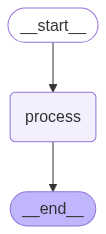

In [8]:
# Simplified Socratic Bot Logic

import os
import json
import re
from typing import List, Dict, TypedDict, Annotated, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

load_dotenv()

# --- Simplified State ---
class SocraticState(TypedDict):
    """Simplified state for the Socratic tutor"""
    messages: Annotated[List[BaseMessage], add_messages]
    topic: str
    difficulty_level: str
    user_struggle_count: int
    current_mcq: Optional[Dict]  # None or {"question": str, "options": List[str], "correct_answer": str, "explanation": str}

# --- Initialize LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", max_retries=3, temperature=0.7)

# --- Predefined MCQs ---
PREDEFINED_MCQS = {
    "variables": {
        "question": "Which of the following data types is mutable in Python?",
        "options": ["Tuple", "String", "List", "Integer"],
        "correct_answer": "C",
        "explanation": "Lists are mutable in Python, meaning you can change their contents after creation."
    },
    "functions": {
        "question": "Which keyword is used to define a function in Python?",
        "options": ["func", "define", "def", "function"],
        "correct_answer": "C",
        "explanation": "The 'def' keyword is used to define functions in Python."
    },
    "classes": {
        "question": "What is the primary purpose of the __init__ method in a class?",
        "options": [
            "To destroy an object when it's no longer needed",
            "To define static methods",
            "To initialize the attributes of an object when it's created",
            "To define the string representation of an object"
        ],
        "correct_answer": "C",
        "explanation": "The __init__ method is called when an object is created and is used to initialize its attributes."
    }
}

# --- System Prompt ---
SYSTEM_PROMPT = """You are a Socratic Python programming tutor. Your core principle is to guide students to discover answers through thoughtful questions rather than giving direct answers.

**Your approach:**
1. Ask guiding questions to help students think through problems
2. Break complex topics into smaller, manageable concepts
3. Encourage experimentation and exploration
4. Adapt your questioning based on student responses
5. Be patient and encouraging

**Current context:**
- Topic: {topic}
- Difficulty: {difficulty_level}
- Student struggles: {user_struggle_count}
- Active MCQ: {has_mcq}

**Guidelines:**
- Always respond with questions unless providing feedback
- If a student struggles (wrong answers, confusion), simplify your approach
- You can offer MCQs to test understanding
- Keep responses concise and focused
- Encourage hands-on practice

Start by asking what Python topic they'd like to explore or if they want to test their knowledge."""

# --- Core Functions ---
def generate_mcq(topic: str, difficulty: str) -> Dict:
    """Generate an MCQ for the given topic"""
    # First check predefined MCQs
    if topic.lower() in PREDEFINED_MCQS:
        return PREDEFINED_MCQS[topic.lower()]
    
    # Generate using LLM for other topics
    prompt = f"""Generate a multiple choice question about {topic} at {difficulty} level.
    
    Return ONLY a JSON object with this exact structure:
    {{
        "question": "Your question here",
        "options": ["Option A", "Option B", "Option C", "Option D"],
        "correct_answer": "C",
        "explanation": "Brief explanation of the correct answer"
    }}"""
    
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        
        # Clean up the response
        content = re.sub(r'^```json\s*', '', content)
        content = re.sub(r'\s*```$', '', content)
        
        mcq_data = json.loads(content)
        
        # Validate structure
        required_keys = ["question", "options", "correct_answer", "explanation"]
        if all(key in mcq_data for key in required_keys):
            return mcq_data
        else:
            raise ValueError("Invalid MCQ structure")
            
    except Exception as e:
        print(f"Error generating MCQ: {e}")
        # Return a default MCQ
        return {
            "question": f"What is an important concept in {topic}?",
            "options": ["Syntax", "Logic", "Practice", "All of the above"],
            "correct_answer": "D",
            "explanation": "All aspects are important when learning programming concepts."
        }

def process_user_input(state: SocraticState) -> SocraticState:
    """Main function to process user input and generate response"""
    last_message = state["messages"][-1]
    
    if not isinstance(last_message, HumanMessage):
        return state
    
    user_input = last_message.content.strip()
    
    # Check if this is an MCQ answer
    if state["current_mcq"] and re.match(r'^[ABCD]$', user_input.upper()):
        return handle_mcq_answer(state, user_input.upper())
    
    # Check if user is requesting an MCQ
    if any(keyword in user_input.lower() for keyword in ["mcq", "quiz", "test", "question"]):
        return handle_mcq_request(state)
    
    # Regular Socratic response
    return generate_socratic_response(state)

def handle_mcq_answer(state: SocraticState, user_answer: str) -> SocraticState:
    """Handle MCQ answer submission"""
    mcq = state["current_mcq"]
    correct_answer = mcq["correct_answer"]
    
    is_correct = user_answer == correct_answer
    
    if is_correct:
        response = f"Correct! 🎉\n\n{mcq['explanation']}\n\nWhat would you like to explore next?"
        state["user_struggle_count"] = max(0, state["user_struggle_count"] - 1)
    else:
        response = f"Not quite. The correct answer is {correct_answer}.\n\n{mcq['explanation']}\n\nLet's break this down further. What part of this concept would you like to understand better?"
        state["user_struggle_count"] += 1
    
    state["current_mcq"] = None  # Clear the MCQ
    state["messages"].append(AIMessage(content=response))
    
    return state

def handle_mcq_request(state: SocraticState) -> SocraticState:
    """Handle request for MCQ"""
    topic = state["topic"] or "Python basics"
    difficulty = state["difficulty_level"]
    
    mcq = generate_mcq(topic, difficulty)
    state["current_mcq"] = mcq
    
    # Format the MCQ for display
    options_text = "\n".join([f"{chr(65+i)}) {option}" for i, option in enumerate(mcq["options"])])
    mcq_text = f"**{mcq['question']}**\n\n{options_text}\n\nPlease answer with A, B, C, or D."
    
    state["messages"].append(AIMessage(content=mcq_text))
    return state

def generate_socratic_response(state: SocraticState) -> SocraticState:
    """Generate a Socratic response using the LLM"""
    # Extract topic from conversation if not set
    if not state["topic"]:
        last_human_msg = state["messages"][-1].content
        # Simple topic extraction - you could make this more sophisticated
        if any(word in last_human_msg.lower() for word in ["function", "def"]):
            state["topic"] = "functions"
        elif any(word in last_human_msg.lower() for word in ["class", "object"]):
            state["topic"] = "classes"
        elif any(word in last_human_msg.lower() for word in ["variable", "assignment"]):
            state["topic"] = "variables"
        else:
            state["topic"] = "Python basics"
    
    # Create prompt with current context
    prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages")
    ])
    
    # Get response from LLM
    response = prompt.invoke({
        "messages": state["messages"],
        "topic": state["topic"],
        "difficulty_level": state["difficulty_level"],
        "user_struggle_count": state["user_struggle_count"],
        "has_mcq": state["current_mcq"] is not None
    })
    
    ai_response = llm.invoke(response.messages)
    state["messages"].append(AIMessage(content=ai_response.content))
    
    return state

# --- Graph Setup ---
def create_socratic_graph():
    """Create the simplified Socratic tutor graph"""
    workflow = StateGraph(SocraticState)
    
    # Single node that handles all logic
    workflow.add_node("process", process_user_input)
    
    # Simple flow: process -> end
    workflow.set_entry_point("process")
    workflow.add_edge("process", END)
    
    # Compile with memory
    memory_saver = MemorySaver()
    return workflow.compile(checkpointer=memory_saver)

# Create the graph instance
socratic_graph = create_socratic_graph()

socratic_graph
# # --- Helper function for Streamlit ---
# def run_socratic_session(user_input: str, thread_id: str, current_state: SocraticState = None) -> SocraticState:
#     """Run a single interaction with the Socratic tutor"""
#     if current_state is None:
#         current_state = SocraticState(
#             messages=[],
#             topic="",
#             difficulty_level="beginner",
#             user_struggle_count=0,
#             current_mcq=None
#         )
    
#     # Add user message
#     current_state["messages"].append(HumanMessage(content=user_input))
    
#     # Process through graph
#     result = socratic_graph.invoke(
#         current_state,
#         config={"configurable": {"thread_id": thread_id}}
#     )
    
#     return result

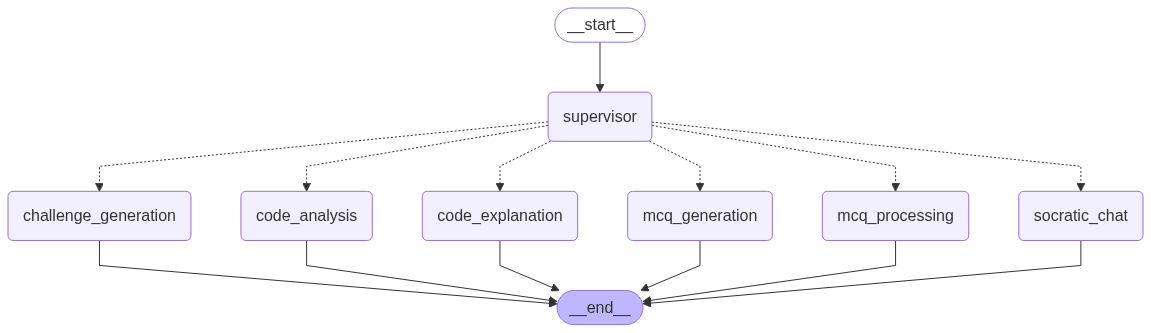

In [10]:
# socratic_bot_logic_enhanced.py
import os
from typing import List, TypedDict, Annotated, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import json

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    next_action: str  # Added for supervisor routing

# --- 2. Initialize the LLMs ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)
supervisor_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.3)

# --- 3. Define Tools ---
@tool
def code_analysis_agent(code: str) -> str:
    """Analyzes the provided Python code and provides feedback."""
    return f"Code Analysis: Your code '{code}' shows good structure. What specific aspect would you like to improve?"

@tool
def code_explanation_agent(concept: str) -> str:
    """Explains a given Python concept using the Socratic method."""
    return f"Let's explore '{concept}' together. What do you think this concept does based on its name?"

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """Generates a Python coding challenge based on topic and difficulty."""
    challenges = {
        "variables": "Create a program that swaps two variables without using a third variable.",
        "functions": "Write a function that calculates the factorial of a number.",
        "loops": "Create a function that prints the Fibonacci sequence up to n terms.",
        "classes": "Design a simple class to represent a bank account with deposit and withdraw methods."
    }
    challenge = challenges.get(topic.lower(), f"Create a simple program demonstrating {topic}.")
    return f"Challenge: {challenge} How would you approach this problem?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level.
    Returns a JSON string containing the question, options, and correct answer.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "class": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed.",
                "B) To define static methods.",
                "C) To initialize the attributes of an object when it's created.",
                "D) To define the string representation of an object."
            ],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "conditional statements": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        },
        "comparisons": {
            "question": "What is the correct operator for 'not equal to' in Python?",
            "options": ["A) ==", "B) !=", "C) <>", "D) =!"],
            "correct_answer": "B"
        },
        "maximum of three numbers": {
            "question": "Consider finding the maximum of three numbers (a, b, c). Which of these logical structures is typically used?",
            "options": [
                "A) A single 'for' loop",
                "B) Nested 'if-else' statements or multiple 'if' statements with logical 'and'/'or'",
                "C) A 'while' loop",
                "D) A 'try-except' block"
            ],
            "correct_answer": "B"
        }
    }
    
    selected_mcq_raw = mcqs_raw.get(topic.lower())

    if selected_mcq_raw:
        formatted_question = f"**{selected_mcq_raw['question']}**\n\n" + \
                             "\n".join(selected_mcq_raw['options'])

        mcq_data = {
            "question": formatted_question,
            "options": selected_mcq_raw['options'],
            "correct_answer": selected_mcq_raw['correct_answer']
        }
        return json.dumps(mcq_data)
    else:
        return "NO_PREDEFINED_MCQ_FOUND"

@tool
def llm_mcq_generator(topic: str, difficulty: str) -> str:
    """
    Generates a new multiple-choice question using LLM for topics not in predefined list.
    """
    mcq_prompt_template = ChatPromptTemplate.from_messages([
        ("system", """
        You are an expert Python programming instructor. Generate a challenging
        but fair multiple-choice question (MCQ) on the given Python topic and difficulty level.
        The MCQ should have exactly four options (A, B, C, D).
        Provide the question, the four options, and the single correct answer in JSON format.
        
        Example Output:
        {
            "question": "What is the purpose of a 'for' loop in Python?",
            "options": ["A) To define a function.", "B) To iterate over a sequence.", "C) To handle exceptions.", "D) To create a new class."],
            "correct_answer": "B"
        }
        """),
        ("user", f"Generate a Python MCQ about: {topic}. Difficulty: {difficulty}.")
    ])

    try:
        response = mcq_generation_llm.invoke(mcq_prompt_template.format(topic=topic, difficulty=difficulty))
        mcq_data = json.loads(response.content)

        if not all(k in mcq_data for k in ["question", "options", "correct_answer"]):
            raise ValueError("MCQ JSON missing required keys.")
        if not isinstance(mcq_data["options"], list) or len(mcq_data["options"]) != 4:
            raise ValueError("MCQ options must be a list of 4 items.")
        if mcq_data["correct_answer"] not in ["A", "B", "C", "D"]:
            raise ValueError("Correct answer must be A, B, C, or D.")

        formatted_question = f"**{mcq_data['question']}**\n\n" + \
                             "\n".join(mcq_data['options'])

        return json.dumps({
            "question": formatted_question,
            "options": mcq_data['options'],
            "correct_answer": mcq_data['correct_answer']
        })

    except json.JSONDecodeError:
        return json.dumps({"error": "Failed to decode JSON from LLM for MCQ generation."})
    except ValueError as e:
        return json.dumps({"error": f"Invalid MCQ format generated by LLM: {e}"})
    except Exception as e:
        return json.dumps({"error": f"An unexpected error occurred during MCQ generation: {e}"})

@tool
def mcq_answer_processor(user_answer: str, correct_answer: str) -> str:
    """
    Processes the user's answer to an MCQ and provides feedback.
    """
    is_correct = user_answer.strip().upper() == correct_answer.strip().upper()
    if is_correct:
        return "Correct! Great job understanding the concept."
    else:
        return f"Incorrect. The correct answer is {correct_answer}. Let's explore why."

# --- 4. Supervisor System ---
supervisor_system_prompt = """
You are a supervisor for a Socratic Python tutoring system. Your role is to analyze the user's message 
and current state to determine the most appropriate action to take.

Available actions:
1. "socratic_chat" - For general Socratic questioning and discussion
2. "code_analysis" - When user provides code for review
3. "code_explanation" - When user asks for explanation of concepts
4. "challenge_generation" - When user wants a coding challenge
5. "mcq_generation" - When user wants a multiple choice question or when you detect they're struggling
6. "mcq_processing" - When user is answering an active MCQ
7. "direct_response" - For simple acknowledgments or when continuing conversation

Consider the following factors:
- User's current struggle count (higher = more support needed)
- Whether an MCQ is currently active
- The nature of the user's message (question, code, answer, etc.)
- The current topic and difficulty level

Current state:
- Difficulty level: {difficulty_level}
- Topic: {topic}
- Sub-topic: {sub_topic}
- User struggle count: {user_struggle_count}
- MCQ active: {mcq_active}
- MCQ question: {mcq_question}

Respond with just the action name (e.g., "socratic_chat", "code_analysis", etc.)
"""

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", supervisor_system_prompt),
    ("user", "User message: {user_message}\n\nWhat action should be taken?")
])

def supervisor_node(state: SocraticAgentState):
    """
    Supervisor node that determines the next action based on user input and current state.
    """
    last_message = state["messages"][-1]
    user_message = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Check if MCQ is active and user is providing an answer
    if state.get("mcq_active") and isinstance(last_message, HumanMessage):
        # Check if it looks like an MCQ answer (A, B, C, or D)
        if user_message.strip().upper() in ["A", "B", "C", "D"]:
            return {"next_action": "mcq_processing"}
    
    # Use LLM to determine the best action
    response = supervisor_llm.invoke(supervisor_prompt.format(
        user_message=user_message,
        difficulty_level=state.get("difficulty_level", "beginner"),
        topic=state.get("topic", ""),
        sub_topic=state.get("sub_topic", ""),
        user_struggle_count=state.get("user_struggle_count", 0),
        mcq_active=state.get("mcq_active", False),
        mcq_question=state.get("mcq_question", "")
    ))
    
    action = response.content.strip().lower()
    
    # Map the action to valid routing options
    action_mapping = {
        "socratic_chat": "socratic_chat",
        "code_analysis": "code_analysis",
        "code_explanation": "code_explanation", 
        "challenge_generation": "challenge_generation",
        "mcq_generation": "mcq_generation",
        "mcq_processing": "mcq_processing",
        "direct_response": "socratic_chat"
    }
    
    mapped_action = action_mapping.get(action, "socratic_chat")
    print(f"[DEBUG] Supervisor decided: {mapped_action}")
    
    return {"next_action": mapped_action}

# --- 5. Socratic Chat Node ---
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Core principles:
1. Ask Questions: Always respond with a question unless providing feedback
2. Socratic Method: Break down complex problems into smaller, manageable questions
3. Encourage Exploration: Prompt the user to experiment, research, or think critically
4. Adapt to Understanding: If user struggles, simplify questions or offer hints
5. Maintain Context: Keep track of current topic and sub_topic
6. Be Patient and Encouraging: Foster a positive learning environment

Current state:
- Difficulty level: {difficulty_level}
- Topic: {topic}
- Sub_topic: {sub_topic}
- User struggle count: {user_struggle_count}
- MCQ active: {mcq_active}

Always start your response with "Thought: [your reasoning]" then provide your question or response.
"""

socratic_chat_prompt = ChatPromptTemplate.from_messages([
    ("system", socratic_system_prompt),
    MessagesPlaceholder(variable_name="messages"),
])

def socratic_chat_node(state: SocraticAgentState):
    """
    Main Socratic chat node for asking questions and guiding learning.
    """
    socratic_chain = socratic_chat_prompt | llm
    
    response = socratic_chain.invoke({
        "messages": state["messages"],
        "difficulty_level": state.get("difficulty_level", "beginner"),
        "topic": state.get("topic", ""),
        "sub_topic": state.get("sub_topic", ""),
        "user_struggle_count": state.get("user_struggle_count", 0),
        "mcq_active": state.get("mcq_active", False)
    })
    
    # Extract thought and display content
    thought = ""
    display_content = response.content
    
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        if len(parts) > 1:
            thought = parts[1].strip().split('\n', 1)[0]
            if '\n' in parts[1]:
                display_content = parts[1].split('\n', 1)[1].strip()
            else:
                display_content = ""
    
    new_message = AIMessage(content=display_content)
    return {"messages": [new_message], "agent_thought": thought}

# --- 6. Tool-specific Nodes ---
def code_analysis_node(state: SocraticAgentState):
    """Node for analyzing user's code."""
    last_message = state["messages"][-1]
    code_content = last_message.content
    
    result = code_analysis_agent.invoke({"code": code_content})
    response_message = AIMessage(content=result)
    
    return {"messages": [response_message]}

def code_explanation_node(state: SocraticAgentState):
    """Node for explaining concepts."""
    last_message = state["messages"][-1]
    concept = state.get("topic", last_message.content)
    
    result = code_explanation_agent.invoke({"concept": concept})
    response_message = AIMessage(content=result)
    
    return {"messages": [response_message]}

def challenge_generation_node(state: SocraticAgentState):
    """Node for generating coding challenges."""
    topic = state.get("topic", "general")
    difficulty = state.get("difficulty_level", "beginner")
    
    result = challenge_generator_agent.invoke({"topic": topic, "difficulty": difficulty})
    response_message = AIMessage(content=result)
    
    return {"messages": [response_message]}

def mcq_generation_node(state: SocraticAgentState):
    """Node for generating MCQs."""
    topic = state.get("topic", "variables")
    difficulty = state.get("difficulty_level", "beginner")
    
    # Try predefined MCQ first
    result = mcq_agent.invoke({"topic": topic, "difficulty": difficulty})
    
    if result == "NO_PREDEFINED_MCQ_FOUND":
        # Use LLM to generate MCQ
        result = llm_mcq_generator.invoke({"topic": topic, "difficulty": difficulty})
    
    try:
        mcq_data = json.loads(result)
        if "error" in mcq_data:
            response_message = AIMessage(content=f"Error generating MCQ: {mcq_data['error']}")
            return {"messages": [response_message]}
        
        # Update state with MCQ data
        state_updates = {
            "mcq_active": True,
            "mcq_question": mcq_data.get("question", ""),
            "mcq_options": mcq_data.get("options", []),
            "mcq_correct_answer": mcq_data.get("correct_answer", ""),
            "messages": [AIMessage(content=mcq_data.get("question", ""))]
        }
        
        return state_updates
        
    except json.JSONDecodeError:
        response_message = AIMessage(content="Error: Could not process MCQ data.")
        return {"messages": [response_message]}

def mcq_processing_node(state: SocraticAgentState):
    """Node for processing MCQ answers."""
    last_message = state["messages"][-1]
    user_answer = last_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    
    result = mcq_answer_processor.invoke({"user_answer": user_answer, "correct_answer": correct_answer})
    
    # Update struggle count based on result
    is_correct = user_answer == correct_answer
    new_struggle_count = 0 if is_correct else state.get("user_struggle_count", 0) + 1
    
    response_message = AIMessage(content=result)
    
    return {
        "messages": [response_message],
        "user_struggle_count": new_struggle_count,
        "mcq_active": False,
        "mcq_question": "",
        "mcq_options": [],
        "mcq_correct_answer": ""
    }

# --- 7. Routing Function ---
def route_to_node(state: SocraticAgentState) -> Literal["socratic_chat", "code_analysis", "code_explanation", "challenge_generation", "mcq_generation", "mcq_processing"]:
    """Routes to the appropriate node based on supervisor decision."""
    return state.get("next_action", "socratic_chat")

# --- 8. Build the Enhanced Graph ---
def build_enhanced_socratic_graph():
    """Builds the enhanced Socratic graph with supervisor and memory."""
    
    workflow = StateGraph(SocraticAgentState)
    
    # Add all nodes
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("socratic_chat", socratic_chat_node)
    workflow.add_node("code_analysis", code_analysis_node)
    workflow.add_node("code_explanation", code_explanation_node)
    workflow.add_node("challenge_generation", challenge_generation_node)
    workflow.add_node("mcq_generation", mcq_generation_node)
    workflow.add_node("mcq_processing", mcq_processing_node)
    
    # Set entry point
    workflow.set_entry_point("supervisor")
    
    # Add conditional edges from supervisor to appropriate nodes
    workflow.add_conditional_edges(
        "supervisor",
        route_to_node,
        {
            "socratic_chat": "socratic_chat",
            "code_analysis": "code_analysis",
            "code_explanation": "code_explanation",
            "challenge_generation": "challenge_generation",
            "mcq_generation": "mcq_generation",
            "mcq_processing": "mcq_processing"
        }
    )
    
    # All nodes (except supervisor) end the conversation
    workflow.add_edge("socratic_chat", END)
    workflow.add_edge("code_analysis", END)
    workflow.add_edge("code_explanation", END)
    workflow.add_edge("challenge_generation", END)
    workflow.add_edge("mcq_generation", END)
    workflow.add_edge("mcq_processing", END)
    
    # Add memory saver
    memory = MemorySaver()
    
    # Compile the graph with memory
    return workflow.compile(checkpointer=memory)

# --- 9. Initialize the Enhanced Graph ---
enhanced_socratic_graph = build_enhanced_socratic_graph()

enhanced_socratic_graph


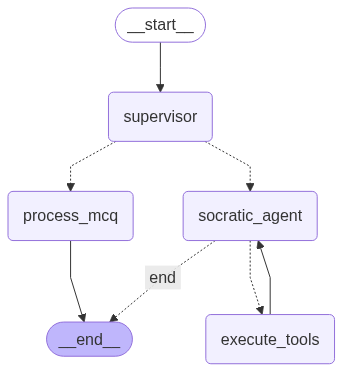

In [11]:
# socratic_bot_logic_enhanced.py
import os
from typing import List, TypedDict, Annotated, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
import json

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    interaction_mode: str  # 'general', 'code_review', 'concept_exploration', 'challenge', 'mcq'
    context_data: dict  # Store relevant context like code, concept, etc.

# --- 2. Initialize the LLMs ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
mcq_generation_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)
supervisor_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.3)

# --- 3. Socratic Tools (Information Gathering Only) ---
@tool
def extract_code_context(code: str) -> str:
    """
    Extracts key information about the provided code for Socratic questioning.
    This tool analyzes code structure, patterns, and potential issues to inform questions.
    """
    context = {
        "code_length": len(code.split('\n')),
        "has_functions": "def " in code,
        "has_classes": "class " in code,
        "has_loops": any(loop in code for loop in ["for ", "while "]),
        "has_conditionals": any(cond in code for cond in ["if ", "elif ", "else"]),
        "imports": [line.strip() for line in code.split('\n') if line.strip().startswith('import') or line.strip().startswith('from')],
        "potential_issues": []
    }
    
    # Check for common issues
    if code.count('(') != code.count(')'):
        context["potential_issues"].append("parentheses_mismatch")
    if "print(" in code and code.count("print(") > 3:
        context["potential_issues"].append("excessive_prints")
    if "global " in code:
        context["potential_issues"].append("global_variables")
    
    return json.dumps(context)

@tool
def analyze_concept_depth(concept: str) -> str:
    """
    Analyzes the depth and complexity of a programming concept for appropriate Socratic questioning.
    """
    concept_mapping = {
        "variables": {"level": "beginner", "prerequisites": [], "subtopics": ["assignment", "naming", "types", "scope"]},
        "functions": {"level": "beginner", "prerequisites": ["variables"], "subtopics": ["definition", "parameters", "return", "scope"]},
        "classes": {"level": "intermediate", "prerequisites": ["functions", "variables"], "subtopics": ["attributes", "methods", "inheritance", "encapsulation"]},
        "loops": {"level": "beginner", "prerequisites": ["variables", "conditionals"], "subtopics": ["for", "while", "iteration", "break", "continue"]},
        "conditionals": {"level": "beginner", "prerequisites": ["variables", "comparisons"], "subtopics": ["if", "elif", "else", "boolean", "logical_operators"]},
        "decorators": {"level": "advanced", "prerequisites": ["functions", "closures"], "subtopics": ["syntax", "parameters", "multiple", "built_in"]},
        "generators": {"level": "advanced", "prerequisites": ["functions", "loops"], "subtopics": ["yield", "iterator", "memory", "lazy_evaluation"]}
    }
    
    concept_info = concept_mapping.get(concept.lower(), {
        "level": "intermediate", 
        "prerequisites": ["basic_python"], 
        "subtopics": ["definition", "usage", "examples"]
    })
    
    return json.dumps(concept_info)

@tool
def generate_mcq_data(topic: str, difficulty: str) -> str:
    """
    Generates MCQ data for Socratic assessment. First tries predefined, then generates new ones.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "classes": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed",
                "B) To define static methods",
                "C) To initialize the attributes of an object when it's created",
                "D) To define the string representation of an object"
            ],
            "correct_answer": "C"
        },
        "loops": {
            "question": "What will happen if you don't include a break statement in a while loop with a condition that never becomes False?",
            "options": ["A) The program will end normally", "B) An error will occur", "C) The loop will run indefinitely", "D) Python will automatically break the loop"],
            "correct_answer": "C"
        },
        "conditionals": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        }
    }
    
    selected_mcq = mcqs_raw.get(topic.lower())
    
    if selected_mcq:
        formatted_question = f"**{selected_mcq['question']}**\n\n" + "\n".join(selected_mcq['options'])
        return json.dumps({
            "question": formatted_question,
            "options": selected_mcq['options'],
            "correct_answer": selected_mcq['correct_answer']
        })
    else:
        # Generate using LLM
        mcq_prompt = ChatPromptTemplate.from_messages([
            ("system", """Generate a Python MCQ in JSON format with 'question', 'options' (array of 4 strings A-D), and 'correct_answer' (A/B/C/D)."""),
            ("user", f"Topic: {topic}, Difficulty: {difficulty}")
        ])
        
        try:
            response = mcq_generation_llm.invoke(mcq_prompt.format())
            mcq_data = json.loads(response.content)
            
            formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data['options'])
            return json.dumps({
                "question": formatted_question,
                "options": mcq_data['options'],
                "correct_answer": mcq_data['correct_answer']
            })
        except:
            return json.dumps({"error": "Could not generate MCQ"})

@tool
def create_challenge_context(topic: str, difficulty: str) -> str:
    """
    Creates challenge context for Socratic guidance through problem-solving.
    """
    challenges = {
        "variables": {
            "problem": "Swapping two variables without using a third variable",
            "key_concepts": ["assignment", "arithmetic", "temporary storage"],
            "guiding_questions": [
                "What methods do you know for swapping values?",
                "How might mathematical operations help?",
                "What happens when you do a = a + b?"
            ]
        },
        "functions": {
            "problem": "Calculating factorial of a number",
            "key_concepts": ["recursion", "iteration", "base case"],
            "guiding_questions": [
                "What is a factorial mathematically?",
                "How would you break this down into smaller problems?",
                "What happens when the number is 0 or 1?"
            ]
        },
        "loops": {
            "problem": "Generating Fibonacci sequence",
            "key_concepts": ["iteration", "sequence", "previous values"],
            "guiding_questions": [
                "How does each Fibonacci number relate to previous ones?",
                "What values do you need to track?",
                "How would you generate the next number?"
            ]
        },
        "classes": {
            "problem": "Creating a simple bank account class",
            "key_concepts": ["encapsulation", "methods", "attributes"],
            "guiding_questions": [
                "What data should a bank account store?",
                "What operations can you perform on an account?",
                "How would you ensure the balance can't be negative?"
            ]
        }
    }
    
    return json.dumps(challenges.get(topic.lower(), {
        "problem": f"Implementing a solution for {topic}",
        "key_concepts": ["problem_solving", "implementation"],
        "guiding_questions": [f"How would you approach solving {topic}?"]
    }))

# --- 4. Supervisor Node ---
supervisor_system_prompt = """
You are a supervisor for a Socratic Python tutoring system. Your role is to determine the interaction mode 
based on the user's message and current state. Remember: EVERYTHING must remain Socratic - we never give direct answers.

Available interaction modes:
1. "general" - General Socratic questioning and topic exploration
2. "code_review" - Socratic code review through guided questions
3. "concept_exploration" - Deep dive into concepts through questioning
4. "challenge" - Guiding through problem-solving via questions
5. "mcq_active" - When user is answering an MCQ
6. "mcq_request" - When user wants an MCQ or needs assessment

Current state:
- Difficulty: {difficulty_level}
- Topic: {topic}
- Sub-topic: {sub_topic}
- Struggle count: {user_struggle_count}
- MCQ active: {mcq_active}
- Current mode: {interaction_mode}

User message indicators:
- Code blocks/snippets → "code_review"
- "explain", "what is", "how does" → "concept_exploration"  
- "challenge", "problem", "exercise" → "challenge"
- "quiz", "test", "MCQ" → "mcq_request"
- A/B/C/D answers when MCQ active → "mcq_active"
- General questions → "general"

Respond with just the mode name.
"""

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", supervisor_system_prompt),
    ("user", "User message: {user_message}")
])

def supervisor_node(state: SocraticAgentState):
    """Determines the interaction mode for Socratic guidance."""
    last_message = state["messages"][-1]
    user_message = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Quick checks for specific patterns
    if state.get("mcq_active") and user_message.strip().upper() in ["A", "B", "C", "D"]:
        return {"interaction_mode": "mcq_active"}
    
    if any(keyword in user_message.lower() for keyword in ["```", "def ", "class ", "import ", "print("]):
        return {"interaction_mode": "code_review", "context_data": {"code": user_message}}
    
    # Use supervisor LLM for more complex decisions
    response = supervisor_llm.invoke(supervisor_prompt.format(
        user_message=user_message,
        difficulty_level=state.get("difficulty_level", "beginner"),
        topic=state.get("topic", ""),
        sub_topic=state.get("sub_topic", ""),
        user_struggle_count=state.get("user_struggle_count", 0),
        mcq_active=state.get("mcq_active", False),
        interaction_mode=state.get("interaction_mode", "general")
    ))
    
    mode = response.content.strip().lower()
    
    # Extract context based on mode
    context_data = {}
    if mode == "code_review":
        context_data = {"code": user_message}
    elif mode == "concept_exploration":
        # Extract concept from message
        concept_keywords = ["variables", "functions", "classes", "loops", "conditionals", "decorators", "generators"]
        for keyword in concept_keywords:
            if keyword in user_message.lower():
                context_data = {"concept": keyword}
                break
        if not context_data:
            context_data = {"concept": state.get("topic", "programming")}
    elif mode == "challenge":
        context_data = {"topic": state.get("topic", "general")}
    
    return {"interaction_mode": mode, "context_data": context_data}

# --- 5. Unified Socratic Node ---
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your CORE PRINCIPLE is to NEVER give direct answers. 
Instead, guide students to discover answers through thoughtful questioning.

INTERACTION MODES:
1. GENERAL: Explore topics through open-ended questions
2. CODE_REVIEW: Guide code improvement through questions about structure, logic, and best practices
3. CONCEPT_EXPLORATION: Deep dive into concepts by asking about understanding, applications, and connections
4. CHALLENGE: Guide problem-solving by breaking down problems into smaller questions
5. MCQ_ACTIVE: Process MCQ answers and provide Socratic feedback
6. MCQ_REQUEST: Generate MCQ and ask guiding questions

SOCRATIC PRINCIPLES:
- Always ask questions, never state facts directly
- Build on student's existing knowledge
- Guide discovery through smaller questions
- Encourage experimentation and thinking
- Adapt question complexity to student's understanding
- Use "What do you think...?", "How might...?", "Can you explain...?" patterns

Current Context:
- Mode: {interaction_mode}
- Topic: {topic}
- Difficulty: {difficulty_level}
- Struggle count: {user_struggle_count}
- MCQ active: {mcq_active}
- Context data: {context_data}

RESPONSE FORMAT:
Always start with "Thought: [your reasoning]" then provide your Socratic question or response.
If you need tool information, call the appropriate tool first, then ask questions based on the results.
"""

socratic_prompt = ChatPromptTemplate.from_messages([
    ("system", socratic_system_prompt),
    MessagesPlaceholder(variable_name="messages"),
])

# Tools available to the Socratic agent
tools = [extract_code_context, analyze_concept_depth, generate_mcq_data, create_challenge_context]
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
socratic_agent_runnable = socratic_prompt | llm_with_tools

def socratic_agent_node(state: SocraticAgentState):
    """
    Unified Socratic agent that handles all interactions through questioning.
    """
    response = socratic_agent_runnable.invoke({
        "messages": state["messages"],
        "interaction_mode": state.get("interaction_mode", "general"),
        "topic": state.get("topic", ""),
        "difficulty_level": state.get("difficulty_level", "beginner"),
        "user_struggle_count": state.get("user_struggle_count", 0),
        "mcq_active": state.get("mcq_active", False),
        "context_data": state.get("context_data", {})
    })
    
    # Extract thought and content
    thought = ""
    display_content = response.content
    
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        if len(parts) > 1:
            thought = parts[1].strip().split('\n', 1)[0]
            if '\n' in parts[1]:
                display_content = parts[1].split('\n', 1)[1].strip()
            else:
                display_content = ""
    
    # Handle tool calls if any
    if response.tool_calls:
        return {
            "messages": [AIMessage(content=display_content, tool_calls=response.tool_calls)],
            "agent_thought": thought
        }
    else:
        return {
            "messages": [AIMessage(content=display_content)],
            "agent_thought": thought
        }

# --- 6. Tool Execution Node ---
def execute_tools(state: SocraticAgentState):
    """
    Executes tools and continues with Socratic questioning based on results.
    """
    last_message = state["messages"][-1]
    
    if not (isinstance(last_message, AIMessage) and last_message.tool_calls):
        return {"messages": []}
    
    tool_mapping = {
        "extract_code_context": extract_code_context,
        "analyze_concept_depth": analyze_concept_depth,
        "generate_mcq_data": generate_mcq_data,
        "create_challenge_context": create_challenge_context
    }
    
    tool_messages = []
    state_updates = {}
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        if tool_name in tool_mapping:
            try:
                result = tool_mapping[tool_name].invoke(tool_args)
                tool_messages.append(ToolMessage(content=result, tool_call_id=tool_call["id"]))
                
                # Handle specific tool results
                if tool_name == "generate_mcq_data":
                    try:
                        mcq_data = json.loads(result)
                        if "error" not in mcq_data:
                            state_updates.update({
                                "mcq_active": True,
                                "mcq_question": mcq_data.get("question", ""),
                                "mcq_options": mcq_data.get("options", []),
                                "mcq_correct_answer": mcq_data.get("correct_answer", "")
                            })
                    except json.JSONDecodeError:
                        pass
                        
            except Exception as e:
                tool_messages.append(ToolMessage(content=f"Error: {str(e)}", tool_call_id=tool_call["id"]))
    
    return {"messages": tool_messages, **state_updates}

# --- 7. MCQ Processing Node ---
def process_mcq_answer(state: SocraticAgentState):
    """
    Processes MCQ answers in a Socratic manner.
    """
    last_message = state["messages"][-1]
    user_answer = last_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    
    is_correct = user_answer == correct_answer
    
    # Socratic feedback based on answer
    if is_correct:
        feedback = "Excellent! You got it right. Now, can you explain why the other options were incorrect? What made you choose this answer?"
        new_struggle_count = 0
    else:
        feedback = f"I see you chose {user_answer}. Let's think about this together. What do you think the correct answer might be and why? Can you walk me through your reasoning?"
        new_struggle_count = state.get("user_struggle_count", 0) + 1
    
    return {
        "messages": [AIMessage(content=feedback)],
        "user_struggle_count": new_struggle_count,
        "mcq_active": False,
        "mcq_question": "",
        "mcq_options": [],
        "mcq_correct_answer": "",
        "interaction_mode": "general"
    }

# --- 8. Graph Construction ---
def should_continue_to_tools(state: SocraticAgentState):
    """Check if we need to execute tools."""
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "execute_tools"
    return "end"

def route_from_supervisor(state: SocraticAgentState):
    """Route based on interaction mode."""
    mode = state.get("interaction_mode", "general")
    if mode == "mcq_active":
        return "process_mcq"
    return "socratic_agent"

def build_enhanced_socratic_graph():
    """Build the graph with supervisor and unified Socratic approach."""
    workflow = StateGraph(SocraticAgentState)
    
    # Add nodes
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("socratic_agent", socratic_agent_node)
    workflow.add_node("execute_tools", execute_tools)
    workflow.add_node("process_mcq", process_mcq_answer)
    
    # Set entry point
    workflow.set_entry_point("supervisor")
    
    # Add edges
    workflow.add_conditional_edges(
        "supervisor",
        route_from_supervisor,
        {
            "socratic_agent": "socratic_agent",
            "process_mcq": "process_mcq"
        }
    )
    
    workflow.add_conditional_edges(
        "socratic_agent",
        should_continue_to_tools,
        {
            "execute_tools": "execute_tools",
            "end": END
        }
    )
    
    workflow.add_edge("execute_tools", "socratic_agent")
    workflow.add_edge("process_mcq", END)
    
    # Add memory
    memory = MemorySaver()
    return workflow.compile(checkpointer=memory)

# --- 9. Initialize System ---
enhanced_socratic_graph = build_enhanced_socratic_graph()
enhanced_socratic_graph


In [12]:
def create_initial_state():
    """Create initial state for new conversations."""
    return {
        "messages": [],
        "difficulty_level": "beginner",
        "user_struggle_count": 0,
        "topic": "",
        "sub_topic": "",
        "mcq_active": False,
        "mcq_question": "",
        "mcq_options": [],
        "mcq_correct_answer": "",
        "agent_thought": "",
        "interaction_mode": "general",
        "context_data": {}
    }

def run_socratic_conversation(user_input: str, thread_id: str = "default"):
    """
    Run a fully Socratic conversation.
    """
    config = {"configurable": {"thread_id": thread_id}}
    
    state = create_initial_state()
    state["messages"] = [HumanMessage(content=user_input)]
    
    try:
        result = enhanced_socratic_graph.invoke(state, config=config)
        
        # Return the last AI message
        for message in reversed(result["messages"]):
            if isinstance(message, AIMessage):
                return message.content
        
        return "What Python topic would you like to explore today? What interests you most about programming?"
        
    except Exception as e:
        print(f"Error: {e}")
        return "I'm having trouble processing that. Can you tell me what you'd like to learn about in Python?"

# --- 10. Test the System ---
if __name__ == "__main__":
    print("=== Fully Socratic Python Tutor ===")
    print("🎯 Everything is Socratic - no direct answers, only guiding questions!")
    print("📚 Supports: Code Review, Concept Exploration, Challenges, MCQs")
    print("🧠 Memory-enabled for persistent learning")
    print("\n" + "="*50 + "\n")
    
    # Test scenarios
    test_scenarios = [
        "I want to learn about variables",
        "def add(a, b):\n    return a + b\n\nIs this code correct?",
        "Explain what a function is",
        "Give me a coding challenge",
        "Can I have an MCQ on loops?",
    ]
    
    for i, scenario in enumerate(test_scenarios, 1):
        print(f"\n--- Test {i}: {scenario[:30]}... ---")
        response = run_socratic_conversation(scenario, f"test_{i}")
        print(f"Socratic Response: {response}")
    
    print("\n" + "="*50)
    print("✅ Fully Socratic Python Tutor Ready!")
    print("Key Features:")
    print("🔍 Supervisor-driven interaction routing")
    print("❓ Pure Socratic method - only questions")
    print("🧠 Memory persistence across sessions")
    print("🔧 Context-aware tool usage")
    print("📊 Adaptive difficulty and struggle tracking")

=== Fully Socratic Python Tutor ===
🎯 Everything is Socratic - no direct answers, only guiding questions!
📚 Supports: Code Review, Concept Exploration, Challenges, MCQs
🧠 Memory-enabled for persistent learning



--- Test 1: I want to learn about variable... ---
Socratic Response: What do you think a variable is in programming?

--- Test 2: def add(a, b):
    return a + ... ---
Socratic Response: Given the code `def add(a, b):\n    return a + b`, what aspects come to mind when you consider if it's "correct"? What do you think this function is intended to do?

--- Test 3: Explain what a function is... ---
Error: 'list' object has no attribute 'startswith'
Socratic Response: I'm having trouble processing that. Can you tell me what you'd like to learn about in Python?

--- Test 4: Give me a coding challenge... ---
Socratic Response: What kind of topic are you interested in, and what difficulty level would you prefer (beginner, intermediate, advanced)?

--- Test 5: Can I have an MCQ on loo

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 24
}
].


Socratic Response: Here's a multiple-choice question for you:

**What will happen if you don't include a break statement in a `while` loop with a condition that never becomes `False`?**

A) The program will end normally
B) An error will occur
C) The loop will run indefinitely
D) Python will automatically break the loop

What do you think is the correct answer, and more importantly, can you explain *why* you think that's the case?

✅ Fully Socratic Python Tutor Ready!
Key Features:
🔍 Supervisor-driven interaction routing
❓ Pure Socratic method - only questions
🧠 Memory persistence across sessions
🔧 Context-aware tool usage
📊 Adaptive difficulty and struggle tracking


In [ ]:
# --- 10. Helper Functions ---
def create_initial_state():
    """Creates initial state for new conversations."""
    return {
        "messages": [],
        "difficulty_level": "beginner",
        "user_struggle_count": 0,
        "topic": "",
        "sub_topic": "",
        "mcq_active": False,
        "mcq_question": "",
        "mcq_options": [],
        "mcq_correct_answer": "",
        "agent_thought": "",
        "next_action": ""
    }

def run_conversation(user_input: str, thread_id: str = "default"):
    """
    Runs a conversation turn with the enhanced Socratic bot.
    
    Args:
        user_input: The user's message
        thread_id: Unique identifier for the conversation thread
    
    Returns:
        The bot's response
    """
    config = {"configurable": {"thread_id": thread_id}}
    
    # Create initial state if needed
    state = create_initial_state()
    state["messages"] = [HumanMessage(content=user_input)]
    
    try:
        result = enhanced_socratic_graph.invoke(state, config=config)
        
        # Return the last AI message content
        for message in reversed(result["messages"]):
            if isinstance(message, AIMessage):
                return message.content
        
        return "I'm here to help you learn Python! What would you like to explore?"
        
    except Exception as e:
        print(f"Error in conversation: {e}")
        return "I encountered an error. Let's try again!"

# --- 11. Test the Enhanced System ---
if __name__ == "__main__":
    print("=== Enhanced Socratic Bot with Supervisor and Memory ===")
    print("Features:")
    print("- Supervisor node for intelligent routing")
    print("- Memory saver for conversation persistence")
    print("- Enhanced tool routing and state management")
    print("- Multi-turn conversation support")
    print("\n" + "="*50 + "\n")
    
    # Test conversation
    test_thread = "test_conversation_1"
    
    print("Bot: Hello! I'm your Socratic Python tutor. What would you like to learn today?")
    
    # Simulate a conversation
    responses = [
        "I want to learn about variables",
        "What are variables used for?",
        "Give me an MCQ on variables",
        "C",
        "Can you give me a coding challenge about functions?"
    ]
    
    for user_msg in responses:
        print(f"\nUser: {user_msg}")
        bot_response = run_conversation(user_msg, test_thread)
        print(f"Bot: {bot_response}")
    
    print("\n" + "="*50)
    print("Enhanced Socratic Bot is ready!")
    print("Key improvements:")
    print("✓ Supervisor node for intelligent routing")
    print("✓ Memory persistence across conversations")
    print("✓ Better state management")
    print("✓ Modular node architecture")
    print("✓ Enhanced error handling")

In [ ]:
# socratic_bot_logic_enhanced.py
import os
from typing import List, TypedDict, Annotated, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
import json
from langchain_groq import ChatGroq

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    interaction_mode: str  # 'general', 'code_review', 'concept_exploration', 'challenge', 'mcq'
    context_data: dict  # Store relevant context like code, concept, etc.

# --- 2. Initialize the LLMs ---

groq_api_key = os.getenv("GROQ_API")
llm = ChatGroq(model = "llama3-8b-8192", temperature=0.7)
mcq_generation_llm = ChatGroq(model = "llama3-70b-8192", temperature=0.5)
supervisor_llm = ChatGroq(model = "llama3-70b-8192", temperature=0.3)

# --- 3. Socratic Tools (Information Gathering Only) ---
@tool
def extract_code_context(code: str) -> str:
    """
    Extracts key information about the provided code for Socratic questioning.
    This tool analyzes code structure, patterns, and potential issues to inform questions.
    """
    context = {
        "code_length": len(code.split('\n')),
        "has_functions": "def " in code,
        "has_classes": "class " in code,
        "has_loops": any(loop in code for loop in ["for ", "while "]),
        "has_conditionals": any(cond in code for cond in ["if ", "elif ", "else"]),
        "imports": [line.strip() for line in code.split('\n') if line.strip().startswith('import') or line.strip().startswith('from')],
        "potential_issues": []
    }
    
    # Check for common issues
    if code.count('(') != code.count(')'):
        context["potential_issues"].append("parentheses_mismatch")
    if "print(" in code and code.count("print(") > 3:
        context["potential_issues"].append("excessive_prints")
    if "global " in code:
        context["potential_issues"].append("global_variables")
    
    return json.dumps(context)

@tool
def analyze_concept_depth(concept: str) -> str:
    """
    Analyzes the depth and complexity of a programming concept for appropriate Socratic questioning.
    """
    concept_mapping = {
        "variables": {"level": "beginner", "prerequisites": [], "subtopics": ["assignment", "naming", "types", "scope"]},
        "functions": {"level": "beginner", "prerequisites": ["variables"], "subtopics": ["definition", "parameters", "return", "scope"]},
        "classes": {"level": "intermediate", "prerequisites": ["functions", "variables"], "subtopics": ["attributes", "methods", "inheritance", "encapsulation"]},
        "loops": {"level": "beginner", "prerequisites": ["variables", "conditionals"], "subtopics": ["for", "while", "iteration", "break", "continue"]},
        "conditionals": {"level": "beginner", "prerequisites": ["variables", "comparisons"], "subtopics": ["if", "elif", "else", "boolean", "logical_operators"]},
        "decorators": {"level": "advanced", "prerequisites": ["functions", "closures"], "subtopics": ["syntax", "parameters", "multiple", "built_in"]},
        "generators": {"level": "advanced", "prerequisites": ["functions", "loops"], "subtopics": ["yield", "iterator", "memory", "lazy_evaluation"]}
    }
    
    concept_info = concept_mapping.get(concept.lower(), {
        "level": "intermediate", 
        "prerequisites": ["basic_python"], 
        "subtopics": ["definition", "usage", "examples"]
    })
    
    return json.dumps(concept_info)

@tool
def generate_mcq_data(topic: str, difficulty: str) -> str:
    """
    Generates MCQ data for Socratic assessment. First tries predefined, then generates new ones.
    """
    mcqs_raw = {
        "variables": {
            "question": "Which of the following data types is mutable in Python?",
            "options": ["A) Tuple", "B) String", "C) List", "D) Integer"],
            "correct_answer": "C"
        },
        "functions": {
            "question": "Which keyword is used to define a function in Python?",
            "options": ["A) func", "B) define", "C) def", "D) function"],
            "correct_answer": "C"
        },
        "classes": {
            "question": "In Python, what is the primary purpose of the `__init__` method in a class?",
            "options": [
                "A) To destroy an object when it's no longer needed",
                "B) To define static methods",
                "C) To initialize the attributes of an object when it's created",
                "D) To define the string representation of an object"
            ],
            "correct_answer": "C"
        },
        "loops": {
            "question": "What will happen if you don't include a break statement in a while loop with a condition that never becomes False?",
            "options": ["A) The program will end normally", "B) An error will occur", "C) The loop will run indefinitely", "D) Python will automatically break the loop"],
            "correct_answer": "C"
        },
        "conditionals": {
            "question": "Which Python keyword is used to start an 'if' statement?",
            "options": ["A) then", "B) if", "C) when", "D) check"],
            "correct_answer": "B"
        }
    }
    
    selected_mcq = mcqs_raw.get(topic.lower())
    
    if selected_mcq:
        formatted_question = f"**{selected_mcq['question']}**\n\n" + "\n".join(selected_mcq['options'])
        return json.dumps({
            "question": formatted_question,
            "options": selected_mcq['options'],
            "correct_answer": selected_mcq['correct_answer']
        })
    else:
        # Generate using LLM
        mcq_prompt = ChatPromptTemplate.from_messages([
            ("system", """Generate a Python MCQ in JSON format with 'question', 'options' (array of 4 strings A-D), and 'correct_answer' (A/B/C/D)."""),
            ("user", f"Topic: {topic}, Difficulty: {difficulty}")
        ])
        
        try:
            response = mcq_generation_llm.invoke(mcq_prompt.format())
            mcq_data = json.loads(response.content)
            
            formatted_question = f"**{mcq_data['question']}**\n\n" + "\n".join(mcq_data['options'])
            return json.dumps({
                "question": formatted_question,
                "options": mcq_data['options'],
                "correct_answer": mcq_data['correct_answer']
            })
        except:
            return json.dumps({"error": "Could not generate MCQ"})

@tool
def create_challenge_context(topic: str, difficulty: str) -> str:
    """
    Creates challenge context for Socratic guidance through problem-solving.
    """
    challenges = {
        "variables": {
            "problem": "Swapping two variables without using a third variable",
            "key_concepts": ["assignment", "arithmetic", "temporary storage"],
            "guiding_questions": [
                "What methods do you know for swapping values?",
                "How might mathematical operations help?",
                "What happens when you do a = a + b?"
            ]
        },
        "functions": {
            "problem": "Calculating factorial of a number",
            "key_concepts": ["recursion", "iteration", "base case"],
            "guiding_questions": [
                "What is a factorial mathematically?",
                "How would you break this down into smaller problems?",
                "What happens when the number is 0 or 1?"
            ]
        },
        "loops": {
            "problem": "Generating Fibonacci sequence",
            "key_concepts": ["iteration", "sequence", "previous values"],
            "guiding_questions": [
                "How does each Fibonacci number relate to previous ones?",
                "What values do you need to track?",
                "How would you generate the next number?"
            ]
        },
        "classes": {
            "problem": "Creating a simple bank account class",
            "key_concepts": ["encapsulation", "methods", "attributes"],
            "guiding_questions": [
                "What data should a bank account store?",
                "What operations can you perform on an account?",
                "How would you ensure the balance can't be negative?"
            ]
        }
    }
    
    return json.dumps(challenges.get(topic.lower(), {
        "problem": f"Implementing a solution for {topic}",
        "key_concepts": ["problem_solving", "implementation"],
        "guiding_questions": [f"How would you approach solving {topic}?"]
    }))

# --- 4. Supervisor Node ---
supervisor_system_prompt = """
You are a supervisor for a Socratic Python tutoring system. Your role is to determine the interaction mode 
based on the user's message and current state. Remember: EVERYTHING must remain Socratic - we never give direct answers.

Available interaction modes:
1. "general" - General Socratic questioning and topic exploration
2. "code_review" - Socratic code review through guided questions
3. "concept_exploration" - Deep dive into concepts through questioning
4. "challenge" - Guiding through problem-solving via questions
5. "mcq_active" - When user is answering an MCQ
6. "mcq_request" - When user wants an MCQ or needs assessment
7. "evaluate_understanding" - When the user gives a short, affirmative response (e.g., "Got it", "Ok", "Yes") and the tutor needs to determine if it signifies true understanding or requires further probing.

Current state:
- Difficulty: {difficulty_level}
- Topic: {topic}
- Sub-topic: {sub_topic}
- Struggle count: {user_struggle_count}
- MCQ active: {mcq_active}
- Current mode: {interaction_mode}

User message indicators:
- Code blocks/snippets → "code_review"
- "explain", "what is", "how does" → "concept_exploration"  
- "challenge", "problem", "exercise" → "challenge"
- "quiz", "test", "MCQ" → "mcq_request"
- A/B/C/D answers when MCQ active → "mcq_active"
- Short affirmative responses like "Got it", "Ok", "Yes", "I understand" → "evaluate_understanding"
- General questions or detailed responses → "general"

Respond with just the mode name.
"""

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", supervisor_system_prompt),
    ("user", "User message: {user_message}")
])

def supervisor_node(state: SocraticAgentState):
    """Determines the interaction mode for Socratic guidance."""
    last_message = state["messages"][-1]
    user_message = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Quick checks for specific patterns
    if state.get("mcq_active") and user_message.strip().upper() in ["A", "B", "C", "D"]:
        return {"interaction_mode": "mcq_active"}
    
    if any(keyword in user_message.lower() for keyword in ["```", "def ", "class ", "import ", "print("]):
        return {"interaction_mode": "code_review", "context_data": {"code": user_message}}
    
    # Check for short affirmative responses to trigger 'evaluate_understanding'
    short_affirmative_keywords = ["got it", "ok", "yes", "i understand", "understood", "ahh i see", "i get it now"]
    if any(keyword in user_message.lower() for keyword in short_affirmative_keywords) and len(user_message.split()) <= 5:
        # If it's a short affirmative, force evaluation
        return {"interaction_mode": "evaluate_understanding"}

    # Use supervisor LLM for more complex decisions
    response = supervisor_llm.invoke(supervisor_prompt.format(
        user_message=user_message,
        difficulty_level=state.get("difficulty_level", "beginner"),
        topic=state.get("topic", ""),
        sub_topic=state.get("sub_topic", ""),
        user_struggle_count=state.get("user_struggle_count", 0),
        mcq_active=state.get("mcq_active", False),
        interaction_mode=state.get("interaction_mode", "general")
    ))
    
    mode = response.content.strip().lower()
    
    # Extract context based on mode
    context_data = {}
    if mode == "code_review":
        context_data = {"code": user_message}
    elif mode == "concept_exploration":
        # Extract concept from message
        concept_keywords = ["variables", "functions", "classes", "loops", "conditionals", "decorators", "generators"]
        found_concept = None
        for keyword in concept_keywords:
            if keyword in user_message.lower():
                found_concept = keyword
                break
        if found_concept:
            context_data = {"concept": found_concept}
        else:
            context_data = {"concept": state.get("topic", "programming")} # Fallback to current topic
    elif mode == "challenge":
        context_data = {"topic": state.get("topic", "general")}
    
    return {"interaction_mode": mode, "context_data": context_data}

# --- 5. Unified Socratic Node ---
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your CORE PRINCIPLE is to NEVER give direct answers. 
Instead, guide students to discover answers through thoughtful questioning.

INTERACTION MODES:
1. GENERAL: Explore topics through open-ended questions
2. CODE_REVIEW: Guide code improvement through questions about structure, logic, and best practices
3. CONCEPT_EXPLORATION: Deep dive into concepts by asking about understanding, applications, and connections
4. CHALLENGE: Guide problem-solving by breaking down problems into smaller questions
5. MCQ_ACTIVE: Process MCQ answers and provide Socratic feedback
6. MCQ_REQUEST: Generate MCQ and ask guiding questions
7. EVALUATE_UNDERSTANDING: The user has given a short affirmative response (e.g., "Got it"). Your task is to ask a probing, Socratic question to verify their understanding. Do NOT simply acknowledge their "Got it". Instead, ask them to elaborate, apply the concept, or explain it in their own words. If user_struggle_count is high, consider rephrasing or simplifying.

SOCRATIC PRINCIPLES:
- Always ask questions, never state facts directly
- Build on student's existing knowledge
- Guide discovery through smaller questions
- Encourage experimentation and thinking
- Adapt question complexity to student's understanding
- Use "What do you think...?", "How might...?", "Can you explain...?" patterns

Current Context:
- Mode: {interaction_mode}
- Topic: {topic}
- Difficulty: {difficulty_level}
- Struggle count: {user_struggle_count}
- MCQ active: {mcq_active}
- Context data: {context_data}

RESPONSE FORMAT:
Always start with "Thought: [your reasoning]" then provide your Socratic question or response.
If you need tool information, call the appropriate tool first, then ask questions based on the results.
"""

socratic_prompt = ChatPromptTemplate.from_messages([
    ("system", socratic_system_prompt),
    MessagesPlaceholder(variable_name="messages"),
])

# Tools available to the Socratic agent
tools = [extract_code_context, analyze_concept_depth, generate_mcq_data, create_challenge_context]
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
socratic_agent_runnable = socratic_prompt | llm_with_tools

def socratic_agent_node(state: SocraticAgentState):
    """
    Unified Socratic agent that handles all interactions through questioning.
    """
    response = socratic_agent_runnable.invoke({
        "messages": state["messages"],
        "interaction_mode": state.get("interaction_mode", "general"),
        "topic": state.get("topic", ""),
        "difficulty_level": state.get("difficulty_level", "beginner"),
        "user_struggle_count": state.get("user_struggle_count", 0),
        "mcq_active": state.get("mcq_active", False),
        "context_data": state.get("context_data", {})
    })
    
    # Extract thought and content more robustly
    thought = ""
    actual_content = response.content # Store the original content
    display_content = ""

    if actual_content:
        if actual_content.startswith("Thought:"):
            parts = actual_content.split("Thought:", 1)
            if len(parts) > 1:
                thought_and_rest = parts[1].strip()
                thought_lines = thought_and_rest.split('\n', 1)
                thought = thought_lines[0]
                
                if len(thought_lines) > 1:
                    display_content = thought_lines[1].strip()
                else:
                    # If no newline after thought, use the thought_and_rest as display_content
                    # This ensures something is displayed even if the LLM only gave a thought.
                    display_content = thought_and_rest 
            else:
                # If "Thought:" is there but nothing after it, display original content
                display_content = actual_content
        else:
            # If it doesn't start with "Thought:", display as is
            display_content = actual_content
    
    # Handle tool calls if any
    if response.tool_calls:
        return {
            "messages": [AIMessage(content=display_content, tool_calls=response.tool_calls)],
            "agent_thought": thought
        }
    else:
        return {
            "messages": [AIMessage(content=display_content)],
            "agent_thought": thought
        }

# --- 6. Tool Execution Node ---
def execute_tools(state: SocraticAgentState):
    """
    Executes tools and continues with Socratic questioning based on results.
    """
    last_message = state["messages"][-1]
    
    if not (isinstance(last_message, AIMessage) and last_message.tool_calls):
        return {"messages": []}
    
    tool_mapping = {
        "extract_code_context": extract_code_context,
        "analyze_concept_depth": analyze_concept_depth,
        "generate_mcq_data": generate_mcq_data,
        "create_challenge_context": create_challenge_context
    }
    
    tool_messages = []
    state_updates = {}
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        if tool_name in tool_mapping:
            try:
                result = tool_mapping[tool_name].invoke(tool_args)
                tool_messages.append(ToolMessage(content=result, tool_call_id=tool_call["id"]))
                
                # Handle specific tool results
                if tool_name == "generate_mcq_data":
                    try:
                        mcq_data = json.loads(result)
                        if "error" not in mcq_data:
                            state_updates.update({
                                "mcq_active": True,
                                "mcq_question": mcq_data.get("question", ""),
                                "mcq_options": mcq_data.get("options", []),
                                "mcq_correct_answer": mcq_data.get("correct_answer", "")
                            })
                    except json.JSONDecodeError:
                        pass
                        
            except Exception as e:
                tool_messages.append(ToolMessage(content=f"Error: {str(e)}", tool_call_id=tool_call["id"]))
    
    return {"messages": tool_messages, **state_updates}

# --- 7. MCQ Processing Node ---
def process_mcq_answer(state: SocraticAgentState):
    """
    Processes MCQ answers in a Socratic manner.
    If the answer is incorrect, it increments struggle count and routes back to supervisor.
    """
    last_message = state["messages"][-1]
    user_answer = last_message.content.strip().upper()
    correct_answer = state.get("mcq_correct_answer", "")
    
    # Extract just the letter from the user's response, e.g., "A)" -> "A"
    if len(user_answer) > 0 and user_answer[0] in ["A", "B", "C", "D"]:
        user_answer_letter = user_answer[0]
    else:
        user_answer_letter = "" # Invalid answer format

    is_correct = user_answer_letter == correct_answer
    
    new_struggle_count = state.get("user_struggle_count", 0)
    feedback_message = ""
    next_route = "continue_to_supervisor" # Default to route back to supervisor

    if is_correct:
        feedback_message = "Excellent! You got it right. Now, can you explain why the other options were incorrect? What made you choose this answer?"
        new_struggle_count = 0 # Reset struggle count on correct answer
        next_route = "continue_to_supervisor" # Still route to supervisor to decide next general step
    else:
        feedback_message = f"I see you chose {user_answer_letter}. Let's think about this together. What do you think the correct answer might be and why? Can you walk me through your reasoning?"
        new_struggle_count += 1
        # If struggle count exceeds a threshold, we might want to change topic or difficulty
        # For now, just routing back to supervisor will allow it to re-evaluate based on the new struggle count.
        next_route = "continue_to_supervisor"
    
    return {
        "messages": [AIMessage(content=feedback_message)],
        "user_struggle_count": new_struggle_count,
        "mcq_active": False, # Always set MCQ to inactive after processing an answer
        "mcq_question": "",
        "mcq_options": [],
        "mcq_correct_answer": "",
        "interaction_mode": "general", # Set to general, supervisor will re-evaluate
        "next_route": next_route # Custom key for routing
    }

# --- 8. Graph Construction ---
def should_continue_to_tools(state: SocraticAgentState):
    """Check if we need to execute tools."""
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "execute_tools"
    return "end"

def route_from_supervisor(state: SocraticAgentState):
    """Route based on interaction mode."""
    mode = state.get("interaction_mode", "general")
    if mode == "mcq_active":
        return "process_mcq"
    elif mode == "evaluate_understanding":
        # If the supervisor decided to evaluate understanding, route to socratic_agent
        # The socratic_agent's prompt will handle the probing question
        return "socratic_agent"
    return "socratic_agent"

# New routing logic for after MCQ processing (no longer needed as process_mcq routes directly to supervisor)
# def route_after_mcq_processing(state: SocraticAgentState):
#     """Route after MCQ processing, typically back to supervisor."""
#     # The 'next_route' key is set in process_mcq_answer
#     return state.get("next_route", "supervisor")


def build_enhanced_socratic_graph():
    """Build the graph with supervisor and unified Socratic approach."""
    workflow = StateGraph(SocraticAgentState)
    
    # Add nodes
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("socratic_agent", socratic_agent_node)
    workflow.add_node("execute_tools", execute_tools)
    workflow.add_node("process_mcq", process_mcq_answer)
    
    # Set entry point
    workflow.set_entry_point("supervisor")
    
    # Add edges
    workflow.add_conditional_edges(
        "supervisor",
        route_from_supervisor,
        {
            "socratic_agent": "socratic_agent",
            "process_mcq": "process_mcq",
            # No explicit route for evaluate_understanding here, as it routes to socratic_agent
            # "evaluate_understanding": "socratic_agent" # This is handled by the route_from_supervisor logic
        }
    )
    
    workflow.add_conditional_edges(
        "socratic_agent",
        should_continue_to_tools,
        {
            "execute_tools": "execute_tools",
            "end": END
        }
    )
    
    workflow.add_edge("execute_tools", "socratic_agent")
    
    # Modified edge: process_mcq now routes back to supervisor
    workflow.add_edge("process_mcq", "supervisor") 
    
    # Add memory
    memory = MemorySaver()
    return workflow.compile(checkpointer=memory)

# --- 9. Initialize System ---
enhanced_socratic_graph = build_enhanced_socratic_graph()
# The memory_saver instance needs to be accessible from main.py
memory_saver = MemorySaver() # Define memory_saver here for import in main.py
